# DNA shape features for k-mer nucleotide mutation rate prediction
## TFBS analysis
### Zian Liu
#### Last updated: 7/5/2022


This is the final part of our notebook where we perform the TFBS analyses.

## Setup

First, import libraries:

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import seaborn as sns
from joblib import dump, load, Parallel, delayed
from copy import deepcopy
from collections import Counter
from IPython.display import display
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import eli5
from scipy.stats import pearsonr, spearmanr, fisher_exact, binom_test, kstest, percentileofscore, entropy
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoLarsIC, Lasso, lars_path
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Print version info
import Bio
import matplotlib
import joblib
import scipy
import sklearn
print("Numpy version: ", np.__version__, "\nPandas version: ", pd.__version__, "\nMatplotlib version: ", matplotlib.__version__, 
      "\nSeaborn version: ", sns.__version__, "\nScipy version: ", scipy.__version__, "\nScikit-learn version: ", sklearn.__version__, 
      "\nBiopython version: ", Bio.__version__, "\nJoblib version: ", joblib.__version__, "\neli5 version: ", eli5.__version__)

Numpy version:  1.20.3 
Pandas version:  1.3.4 
Matplotlib version:  3.4.3 
Seaborn version:  0.11.2 
Scipy version:  1.7.1 
Scikit-learn version:  0.24.2 
Biopython version:  1.79 
Joblib version:  1.1.0 
eli5 version:  0.11.0


Import functions from file:

In [3]:
from notebook_functions_all import *

Next, load the files. 

In [6]:
DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Minmax_shape, Eff, \
    Labels_2d, Kfoldobj, Pred_2dneibr, Labels_2dneibr, Minmax_2dneibr, Var_red_neibr, \
    Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, \
    Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, \
    Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, \
    Pred_sc_4dneibr, Labels_sc_4dneibr = load("data_intermediate/import_all_data.joblib")

(24576, 96)
(24576, 4752)
['HelT_L', 'HelT_CL', 'HelT_CR', 'HelT_R', 'Rise_L', 'Rise_CL', 'Rise_CR', 'Rise_R', 'Roll_L', 'Roll_CL']
4752
{'threshold': 0.01}
(24576, 4158)
4158
(24576, 2282)
{'threshold': 0.01}
(24576, 2089)
(24576, 1908)
['C_____' 'G_____' 'T_____' '_C____' '_G____' '_T____' '__C___' '__G___'
 '__T___' '___C__']


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Position-specific mutated shapes

http://compbio.mit.edu/encode-motifs/

Compare HOXA9_1's innate shape distribution and mutation shape distribution. We chose this motif as 1) it is long (18bp), 2) has role in AML.

First, plot the LOGO for HOXA9_1:

In [49]:
TF_logo = pd.read_csv("data_input/TF_1kg/HOXA9_1/motif_HOXA9_1.txt", sep=" ", header=None, skiprows=[0])
TF_logo.pop(0)
TF_logo.columns = ["A", "C", "G", "T"]
display(TF_logo)

A         C         G         T
0   0.386110  0.122124  0.336396  0.155370
1   0.214951  0.503652  0.200027  0.081370
2   0.227199  0.070231  0.558705  0.143864
3   0.087364  0.155173  0.659970  0.097493
4   0.088468  0.597073  0.010847  0.303611
5   0.237567  0.630916  0.020446  0.111071
6   0.883692  0.003551  0.103622  0.009135
7   0.022994  0.004161  0.003712  0.969134
8   0.630635  0.007085  0.003697  0.358584
9   0.954551  0.003419  0.003818  0.038212
10  0.932582  0.012322  0.005304  0.049792
11  0.758713  0.022612  0.031347  0.187327
12  0.320450  0.163437  0.062031  0.454082
13  0.174953  0.127720  0.167458  0.529870
14  0.511837  0.131729  0.146649  0.209785
15  0.382191  0.090904  0.276475  0.250430
16  0.383323  0.080173  0.111038  0.425465

Generate a web logo with Weblogo 3. Make sure to cite them

Get a score for each position (entropy of location):

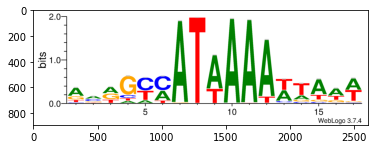

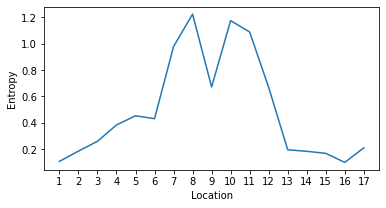

In [52]:
TF_conserve = entropy(TF_logo, qk=np.full(np.shape(TF_logo), fill_value=0.25), axis=1)

plt.figure(figsize=[6, 3])
plt.imshow(matplotlib.image.imread("data_input/TF_1kg/HOXA9_1/logo_HOXA9_1.png"))
plt.show()

fig_out = plt.figure(figsize=[6, 3])
plt.plot(TF_conserve)
plt.xlabel("Location")
plt.ylabel("Entropy")
plt.xticks(np.arange(0, 17), np.arange(1, 18))
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5a_entropy.pdf", dpi=300)

In [53]:
# TFBS shape distribution
DF_pos_shape = pd.read_csv("data_input/TF_1kg/HOXA9_1/shape_HOXA9_1.csv")
# TFBS mutation ref and alt distribution
DF_pos_muts = pd.read_csv("data_input/TF_1kg/HOXA9_1/mutdists_HOXA9_1.bed", 
                          sep="\t", index_col=None, header=None)
DF_pos_muts.columns = ["chr", "start", "end", "mut", "MAF", "pos", "kmer_xtend", "kmer"]
# 5-mer reference DF
DF_strucval_5mersheet = pd.read_csv("data_input/ref_5mers_structure.csv", index_col=0)

display(DF_pos_shape)
display(DF_pos_muts)

HelT_1  HelT_2  HelT_3  HelT_4  HelT_5  HelT_6  HelT_7  HelT_8  \
0        31.94   34.00   33.59   33.62   36.83   33.31   34.95   31.37   
1        35.32   34.83   34.81   31.74   35.53   35.17   34.69   32.46   
2        35.25   32.54   35.00   34.61   35.04   34.22   35.45   31.84   
3        34.75   33.80   33.50   34.37   34.50   34.66   35.45   32.46   
4        31.70   34.25   34.23   35.31   33.98   35.27   35.28   32.42   
...        ...     ...     ...     ...     ...     ...     ...     ...   
167964   36.79   35.22   32.28   37.68   33.17   34.56   35.02   32.42   
167965   35.99   35.62   32.68   34.91   36.69   31.30   34.80   31.87   
167966   31.18   35.50   31.48   34.33   36.12   34.17   35.45   31.84   
167967   35.32   34.83   34.81   31.63   34.61   34.61   35.45   32.46   
167968   34.24   35.58   32.44   36.72   31.46   34.95   34.95   32.63   

        HelT_9  HelT_10  ...  EP_8  EP_9  EP_10  EP_11  EP_12  EP_13  EP_14  \
0        34.57    35.77  ... -6.88 -7.46  -8.39 -10.80  -9.42  -8.13  -6.07   
1        35.37    34.55  ... -7.61 -7.47  -7.41  -8.39 -10.80  -8.51  -7.48   
2        34.57    35.77  ... -6.88 -7.46  -8.39 -10.80 -13.59  -8.38  -7.47   
3        34.72    35.86  ... -7.48 -7.46  -8.29  -8.51  -7.65  -6.79  -6.76   
4        34.72    35.77  ... -7.48 -7.46  -8.39 -10.10 -10.80  -8.51  -7.65   
...        ...      ...  ...   ...   ...    ...    ...    ...    ...    ...   
167964   34.72    35.77  ... -7.48 -7.46  -8.39 -10.10 -10.80  -8.51  -7.51   
167965   34.59    35.77  ... -6.76 -7.46  -8.39 -10.80 -13.59  -8.38  -7.69   
167966   34.57    35.77  ... -6.88 -7.46  -8.39 -10.10 -10.10 -10.80 -13.59   
167967   34.72    35.77  ... -7.48 -7.46  -8.39 -10.10 -10.10 -10.10 -10.80   
167968   35.40    34.55  ... -7.85 -7.47  -7.41  -8.29  -8.76  -9.50  -5.82   

        EP_15  EP_16  EP_17  
0       -7.24  -7.18  -7.36  
1       -7.46  -8.29  -8.51  
2       -7.47  -8.38 -10.92  
3       -7.69  -7.95  -8.06  
4       -7.65  -7.61  -7.55  
...       ...    ...    ...  
167964  -7.21  -6.41  -9.29  
167965  -6.88  -7.31  -5.65  
167966  -8.38  -7.23  -6.73  
167967 -13.59 -13.59  -9.42  
167968  -7.09  -5.75  -8.05  

[167969 rows x 244 columns]

chr      start        end  mut       MAF  pos kmer_xtend   kmer
0      chr1      67220      67227  G>A  0.034039    1    ACCGTGC  CCGTG
1      chr1     158002     158009  A>T  0.342663   13    ATTATTT  TTATT
2      chr1     787880     787887  A>C  0.002269   13    TTTATTT  TTATT
3      chr1     813859     813866  T>C  0.000756    6    TTATGAC  TATGA
4      chr1     817230     817237  A>T  0.834342   12    AAAATTT  AAATT
...     ...        ...        ...  ...       ...  ...        ...    ...
32229  chr9  140553029  140553036  T>A  0.000756    9    TTTTAAT  TTTAA
32230  chr9  140594614  140594621  A>G  0.001513    3    TGGACTT  GGACT
32231  chr9  140646381  140646388  A>G  0.029501    7    TTTATGA  TTATG
32232  chr9  141083335  141083342  A>C  0.000756    2    TGAAGAC  GAAGA
32233  chr9  141083338  141083345  C>T  0.000756    5    AGACATA  GACAT

[32234 rows x 8 columns]

In [54]:
temp_altks = [0] * len(DF_pos_muts)
temp_alt7 = [0] * len(DF_pos_muts)
for i in range(len(temp_altks)):
    temp_kmer, temp_7mer = DF_pos_muts['kmer'][i].upper(), DF_pos_muts['kmer_xtend'][i].upper()
    temp_alt = DF_pos_muts['mut'][i].split(">")[1]
    temp_altks[i] = temp_kmer[0:2] + temp_alt + temp_kmer[3:5]
    temp_alt7[i] = temp_7mer[0:3] + temp_alt + temp_7mer[4:7]
DF_pos_muts['kmer_alt'] = temp_altks
DF_pos_muts['kmer_alt_xtend'] = temp_alt7

display(DF_pos_muts)

chr      start        end  mut       MAF  pos kmer_xtend   kmer  \
0      chr1      67220      67227  G>A  0.034039    1    ACCGTGC  CCGTG   
1      chr1     158002     158009  A>T  0.342663   13    ATTATTT  TTATT   
2      chr1     787880     787887  A>C  0.002269   13    TTTATTT  TTATT   
3      chr1     813859     813866  T>C  0.000756    6    TTATGAC  TATGA   
4      chr1     817230     817237  A>T  0.834342   12    AAAATTT  AAATT   
...     ...        ...        ...  ...       ...  ...        ...    ...   
32229  chr9  140553029  140553036  T>A  0.000756    9    TTTTAAT  TTTAA   
32230  chr9  140594614  140594621  A>G  0.001513    3    TGGACTT  GGACT   
32231  chr9  140646381  140646388  A>G  0.029501    7    TTTATGA  TTATG   
32232  chr9  141083335  141083342  A>C  0.000756    2    TGAAGAC  GAAGA   
32233  chr9  141083338  141083345  C>T  0.000756    5    AGACATA  GACAT   

      kmer_alt kmer_alt_xtend  
0        CCATG        ACCATGC  
1        TTTTT        ATTTTTT  
2        TTCTT        TTTCTTT  
3        TACGA        TTACGAC  
4        AATTT        AAATTTT  
...        ...            ...  
32229    TTAAA        TTTAAAT  
32230    GGGCT        TGGGCTT  
32231    TTGTG        TTTGTGA  
32232    GACGA        TGACGAC  
32233    GATAT        AGATATA  

[32234 rows x 10 columns]

In [55]:
DF_pos_muts.index = [item.upper() for item in DF_pos_muts['kmer'].values]
DF_pos_muts_ref = DF_pos_muts.join(DF_strucval_5mersheet, how="left")
DF_pos_muts_ref.sort_values(by=["pos", "kmer"], inplace=True)
DF_pos_muts.index = DF_pos_muts['kmer_alt']
DF_pos_muts_alt = DF_pos_muts.join(DF_strucval_5mersheet, how="left")
DF_pos_muts_alt.sort_values(by=["pos", "kmer"], inplace=True)

display(DF_pos_muts_ref)
display(DF_pos_muts_alt)

chr      start        end  mut       MAF  pos kmer_xtend   kmer  \
AAAAA   chr1   74852979   74852986  A>C  0.010590    0    AAAAAAG  AAAAA   
AAAAA  chr18   63488513   63488520  A>C  0.001513    0    GAAAAAT  AAAAA   
AAAAA  chr22   34298350   34298357  A>G  0.099849    0    CAAAAAG  AAAAA   
AAAAA   chr3   85241790   85241797  A>C  0.003026    0    AAAAAAT  AAAAA   
AAAAA   chr4  157666431  157666438  A>G  0.009077    0    CAAAAAG  AAAAA   
...      ...        ...        ...  ...       ...  ...        ...    ...   
AATTT  chr21   26998903   26998910  T>A  0.684569   16    aaaTTTT  aaTTT   
CCACT  chr10   86123046   86123053  A>G  0.139183   16    gccACTT  ccACT   
CTATA   chr2  120119366  120119373  A>G  0.157337   16    actATAT  ctATA   
GTATT  chr14   65777369   65777376  A>G  0.010590   16    tgTATTT  gTATT   
TCATT  chr15   37041670   37041677  A>G  0.005295   16    ttcATTA  tcATT   

      kmer_alt kmer_alt_xtend  ...  Tilt_1  Tilt_2  Buckle_1  Opening_1  \
AAAAA    AACAA        AAACAAG  ...   -0.72   -1.22      7.80      -3.71   
AAAAA    AACAA        GAACAAT  ...   -0.72   -1.22      7.80      -3.71   
AAAAA    AAGAA        CAAGAAG  ...   -0.72   -1.22      7.80      -3.71   
AAAAA    AACAA        AAACAAT  ...   -0.72   -1.22      7.80      -3.71   
AAAAA    AAGAA        CAAGAAG  ...   -0.72   -1.22      7.80      -3.71   
...        ...            ...  ...     ...     ...       ...        ...   
AATTT    AAATT        AAAATTT  ...   -0.03    1.02     -3.92      -0.67   
CCACT    CCGCT        GCCGCTT  ...    1.39   -2.21      0.51      -0.36   
CTATA    CTGTA        ACTGTAT  ...    0.12   -0.08     -3.51      -0.67   
GTATT    GTGTT        TGTGTTT  ...    0.45   -0.19     -5.26      -0.67   
TCATT    TCGTT        TTCGTTA  ...    1.24   -0.87     -6.23       0.00   

       ProT_1  Shear_1  Stagger_1  Stretch_1  MGW_1   EP_1  
AAAAA  -16.51     0.18      -0.22       0.03   3.38 -10.10  
AAAAA  -16.51     0.18      -0.22       0.03   3.38 -10.10  
AAAAA  -16.51     0.18      -0.22       0.03   3.38 -10.10  
AAAAA  -16.51     0.18      -0.22       0.03   3.38 -10.10  
AAAAA  -16.51     0.18      -0.22       0.03   3.38 -10.10  
...       ...      ...        ...        ...    ...    ...  
AATTT  -14.95    -0.18      -0.10      -0.01   2.85 -13.59  
CCACT   -7.40     0.11      -0.06      -0.03   5.31  -6.85  
CTATA   -7.69     0.10      -0.03      -0.02   5.79  -6.87  
GTATT  -10.45     0.10      -0.10      -0.01   5.30  -7.43  
TCATT   -9.02     0.10      -0.21      -0.01   4.46  -8.13  

[32234 rows x 30 columns]

chr      start        end  mut       MAF  pos kmer_xtend   kmer  \
AACAA   chr1   74852979   74852986  A>C  0.010590    0    AAAAAAG  AAAAA   
AACAA  chr18   63488513   63488520  A>C  0.001513    0    GAAAAAT  AAAAA   
AACAA   chr3   85241790   85241797  A>C  0.003026    0    AAAAAAT  AAAAA   
AAGAA  chr22   34298350   34298357  A>G  0.099849    0    CAAAAAG  AAAAA   
AAGAA   chr4  157666431  157666438  A>G  0.009077    0    CAAAAAG  AAAAA   
...      ...        ...        ...  ...       ...  ...        ...    ...   
AACTT  chr14   25852867   25852874  T>C  0.002269   16    taaTTTG  aaTTT   
CCGCT  chr10   86123046   86123053  A>G  0.139183   16    gccACTT  ccACT   
CTGTA   chr2  120119366  120119373  A>G  0.157337   16    actATAT  ctATA   
GTGTT  chr14   65777369   65777376  A>G  0.010590   16    tgTATTT  gTATT   
TCGTT  chr15   37041670   37041677  A>G  0.005295   16    ttcATTA  tcATT   

      kmer_alt kmer_alt_xtend  ...  Tilt_1  Tilt_2  Buckle_1  Opening_1  \
AACAA    AACAA        AAACAAG  ...   -0.21    1.80      8.21       0.40   
AACAA    AACAA        GAACAAT  ...   -0.21    1.80      8.21       0.40   
AACAA    AACAA        AAACAAT  ...   -0.21    1.80      8.21       0.40   
AAGAA    AAGAA        CAAGAAG  ...   -2.12    2.94      3.89       0.06   
AAGAA    AAGAA        CAAGAAG  ...   -2.12    2.94      3.89       0.06   
...        ...            ...  ...     ...     ...       ...        ...   
AACTT    AACTT        TAACTTG  ...   -1.12    1.68      1.95       0.42   
CCGCT    CCGCT        GCCGCTT  ...    0.36   -1.25     -2.00       0.47   
CTGTA    CTGTA        ACTGTAT  ...   -0.96    0.46     -4.11       0.46   
GTGTT    GTGTT        TGTGTTT  ...   -0.39    0.59     -6.45       0.54   
TCGTT    TCGTT        TTCGTTA  ...    0.11   -0.21     -8.01       0.76   

       ProT_1  Shear_1  Stagger_1  Stretch_1  MGW_1  EP_1  
AACAA  -10.17     0.26       0.00      -0.04   4.97 -6.22  
AACAA  -10.17     0.26       0.00      -0.04   4.97 -6.22  
AACAA  -10.17     0.26       0.00      -0.04   4.97 -6.22  
AAGAA   -3.46    -0.27       0.12      -0.04   4.80 -6.03  
AAGAA   -3.46    -0.27       0.12      -0.04   4.80 -6.03  
...       ...      ...        ...        ...    ...   ...  
AACTT   -6.26     0.24       0.06      -0.03   3.34 -6.51  
CCGCT   -3.78    -0.25       0.00      -0.03   5.15 -5.00  
CTGTA   -6.49    -0.28       0.09      -0.03   5.41 -5.31  
GTGTT   -9.40    -0.26       0.03      -0.03   5.05 -5.66  
TCGTT   -9.62    -0.26      -0.07      -0.03   4.80 -5.64  

[32234 rows x 30 columns]

Note that the "pos" mentions the position of the mutation k-mer relative to the TFBS 1st base in positive strand, and this range is 0-indexed.

Look at TFBS expected patterns vs mutation patterns at different locations, also calculate: 

* KS statistics between background and alt (only value, p-values are too significant so we won't use them)
* Max range of shape changes

In [56]:
shape_picks = np.arange(np.shape(DF_strucval_5mersheet)[1])
DF_KSstat = np.zeros(shape=(len(shape_picks), max(DF_pos_muts_ref['pos'])+1))
Shape_types = []

j = 0
for i in shape_picks:
    Shape_types.append(DF_pos_muts_ref.columns[10+i])
    for pos_select in range(max(DF_pos_muts_ref['pos'])+1):
        # Temporary calculations
        temp_refval = DF_pos_muts_ref[DF_pos_muts_ref['pos'] == pos_select].iloc[:, 10+i].values
        temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
        colname_shape = DF_pos_muts_ref.columns[10+i]
        colname_shape = colname_shape.split("_")[0] + "_" + str(int(colname_shape.split("_")[1]) + pos_select)
        if colname_shape not in DF_pos_shape.columns:
            continue
        temp_bgval = DF_pos_shape[colname_shape]
        # Add to arrays
        DF_KSstat[j, pos_select] = kstest(temp_bgval, temp_altval)[0]
    j += 1

Plot HelT (both left and right) out:

In [60]:
temp_helt1_df, temp_helt2_df = pd.DataFrame({"value": [], "type": [], "pos": []}), \
                               pd.DataFrame({"value": [], "type": [], "pos": []})

for pos_select in range(max(DF_pos_muts_ref['pos'])+1):
    i = 0
    temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
    colname_shape = DF_pos_muts_ref.columns[10+i]
    colname_shape = "HelT_" + str(int(colname_shape.split("_")[1]) + pos_select)
    if colname_shape not in DF_pos_shape.columns:
        continue
    temp_bgval = DF_pos_shape[colname_shape]
    temp_helt1_df = temp_helt1_df.append(pd.DataFrame({"value": temp_bgval, "type": "background", "pos": int(pos_select)}))
    temp_helt1_df = temp_helt1_df.append(pd.DataFrame({"value": temp_altval, "type": "mutated", "pos": int(pos_select)}))
    
    i = 1
    temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
    colname_shape = DF_pos_muts_ref.columns[10+i]
    colname_shape = "HelT_" + str(int(colname_shape.split("_")[1]) + pos_select)
    if colname_shape not in DF_pos_shape.columns:
        continue
    temp_bgval = DF_pos_shape[colname_shape]
    temp_helt2_df = temp_helt2_df.append(pd.DataFrame({"value": temp_bgval, "type": "background", "pos": int(pos_select)}))
    temp_helt2_df = temp_helt2_df.append(pd.DataFrame({"value": temp_altval, "type": "mutated", "pos": int(pos_select)}))

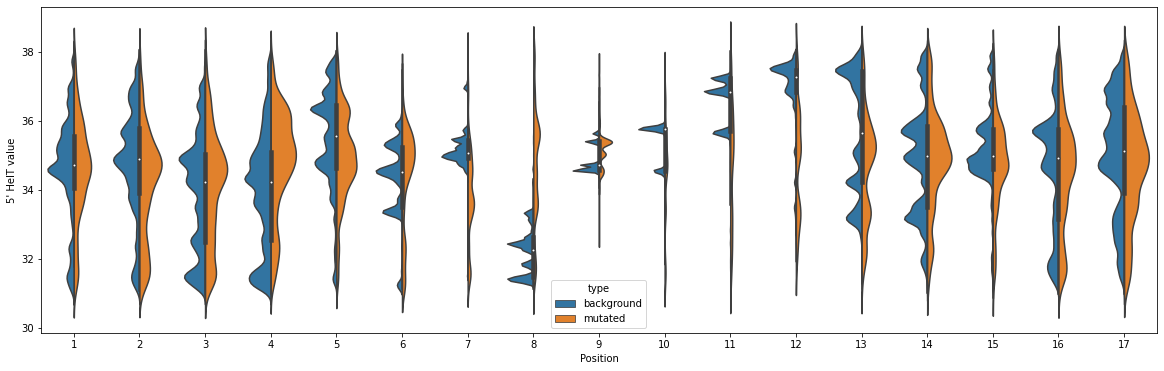

In [61]:
fig_out = plt.figure(figsize=[20, 6])
sns.violinplot(x="pos", y="value", hue="type", data=temp_helt1_df, split=True)
plt.xticks(np.arange(17), np.arange(1, 18, 1))
plt.xlabel("Position")
plt.ylabel("5' HelT value")
fig_out.savefig("manuscript/figures/pltout_fig5b_shapedist.pdf", dpi=300)

Observed mutation rate:

In [62]:
DF_observed_mut = pd.DataFrame([Counter(DF_pos_muts_ref['pos'])]).transpose()
DF_observed_mut.sort_index(inplace=True)
DF_observed_mut = DF_observed_mut / len(DF_pos_shape)
display(DF_observed_mut.T)

0         1         2         3         4         5         6   \
0  0.012324  0.017235  0.015533  0.017289  0.012092  0.009412  0.013306   

        7         8        9         10        11        12        13  \
0  0.01252  0.007305  0.00771  0.005817  0.007174  0.009793  0.011413   

         14        15       16  
0  0.010228  0.011764  0.01099

Spearman correlations between the different values?

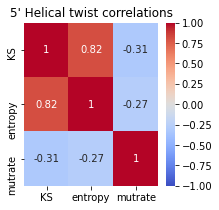

In [67]:
fig_out = plt.figure(figsize=[3, 3])

i = 0
temp_arr = np.array([DF_KSstat[i], TF_conserve, DF_observed_mut.values.flatten()])
temp_corrcoef = np.zeros(shape=(3, 3), dtype=float)
for j in range(3):
    for k in range(3):
        temp_corrcoef[j, k] = spearmanr(temp_arr[j], temp_arr[k])[0]
sns.heatmap(temp_corrcoef, vmin=-1, vmax=1, annot=True, cbar=True, cmap="coolwarm")
plt.xticks([0.5, 1.5, 2.5], ["KS", "entropy", "mutrate"])
plt.yticks([0.5, 1.5, 2.5], ["KS", "entropy", "mutrate"])
plt.title("5' Helical twist correlations")

plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5c_heatmapcorr.pdf", dpi=300)

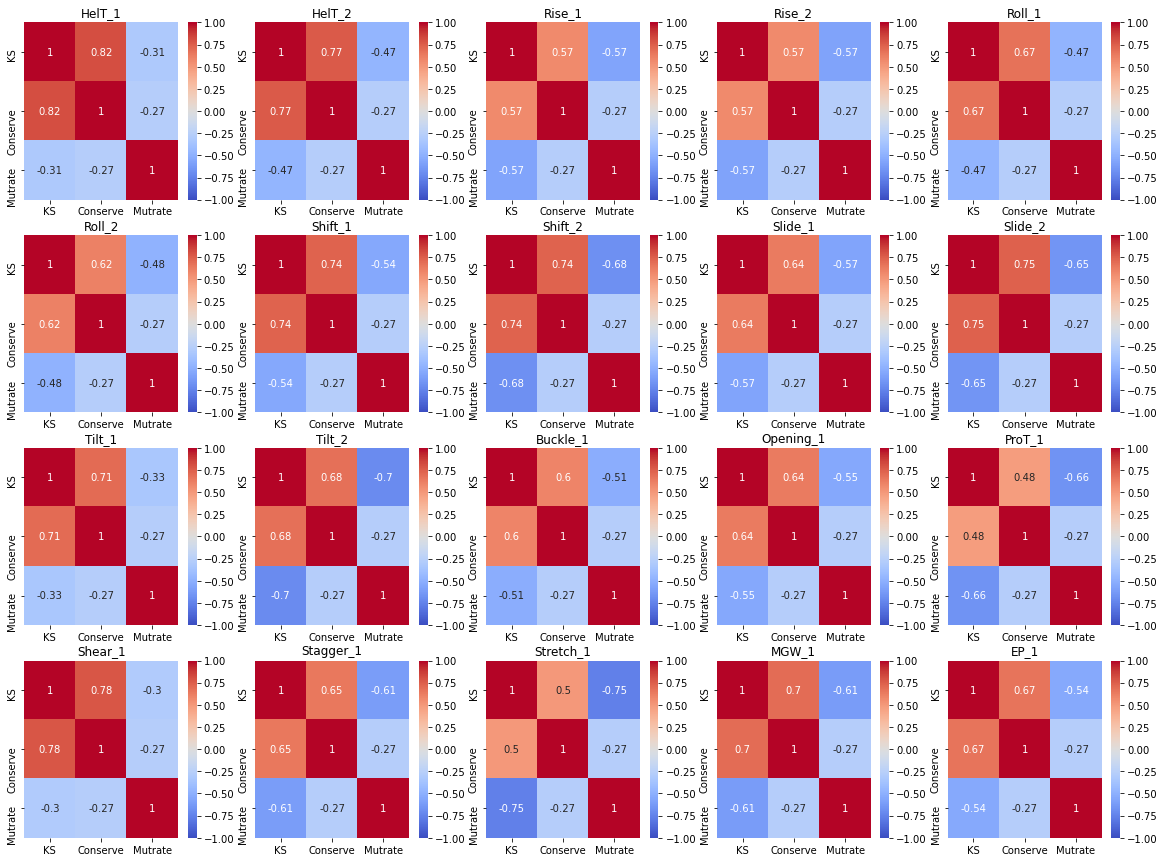

In [28]:
plt.figure(figsize=[20, 15])

for i in range(len(DF_KSstat)):
    plt.subplot(4, 5, i+1)
    temp_arr = np.array([DF_KSstat[i], TF_conserve, DF_observed_mut.values.flatten()])
    temp_corrcoef = np.zeros(shape=(3, 3), dtype=float)
    for j in range(3):
        for k in range(3):
            temp_corrcoef[j, k] = spearmanr(temp_arr[j], temp_arr[k])[0]
    sns.heatmap(temp_corrcoef, vmin=-1, vmax=1, annot=True, cbar=True, cmap="coolwarm")
    plt.xticks([0.5, 1.5, 2.5], ["KS", "Conserve", "Mutrate"])
    plt.yticks([0.5, 1.5, 2.5], ["KS", "Conserve", "Mutrate"])
    plt.title(Shape_types[i])
    
plt.show()

Plot out correlations between KS value (shape alteration between background-alt) and base conservation, with Spearman r value:

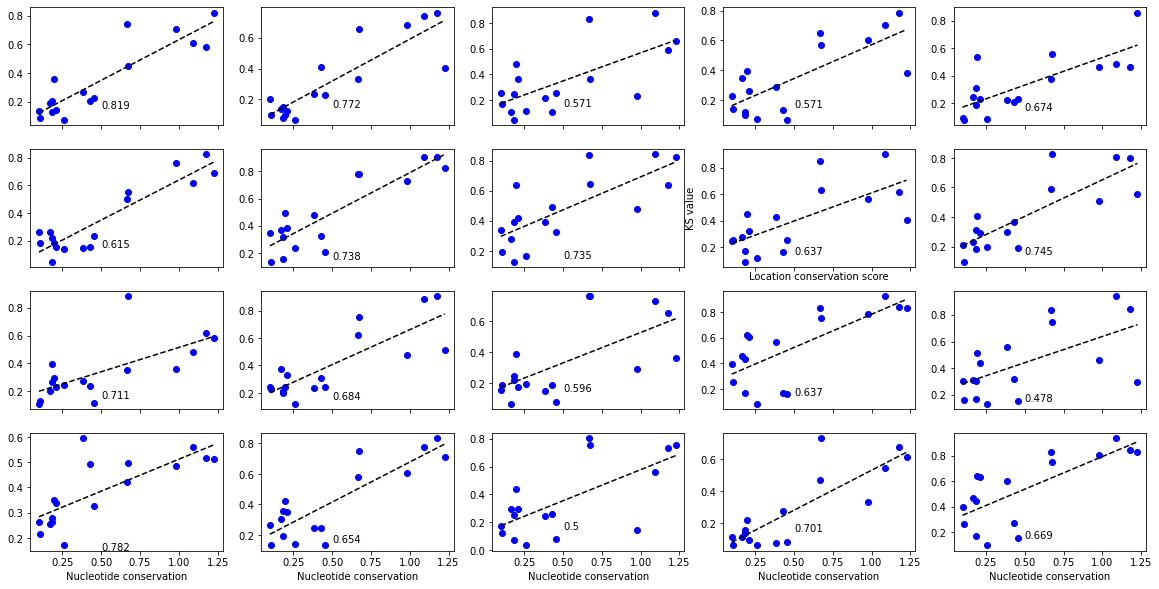

In [68]:
plt.figure(figsize=[20, 10])
for i in range(len(DF_KSstat)):
    plt.subplot(4, 5, i+1)
    #plt.scatter(x=CTCF_conserve, y=DF_KSstat_ctcf[i])
    poly1d_fn = np.poly1d(np.polyfit(TF_conserve, DF_KSstat[i], 1)) 
    plt.plot(TF_conserve, DF_KSstat[i], 'bo', 
             np.sort(TF_conserve), poly1d_fn(np.sort(TF_conserve)), '--k')
    plt.xlabel("Location conservation score")
    if i == 8:
        plt.ylabel("KS value")
        plt.tick_params(labelbottom=False)
    elif i in [15, 16, 17, 18, 19]:
        plt.xlabel("Nucleotide conservation")
    else:
        plt.ylabel("")
        plt.xlabel("")
        plt.tick_params(labelbottom=False)
    plt.annotate(round(spearmanr(TF_conserve, DF_KSstat[i])[0], 3), xy=(0.5, 0.15))
plt.show()

KS statistics vs observed mutation rates:

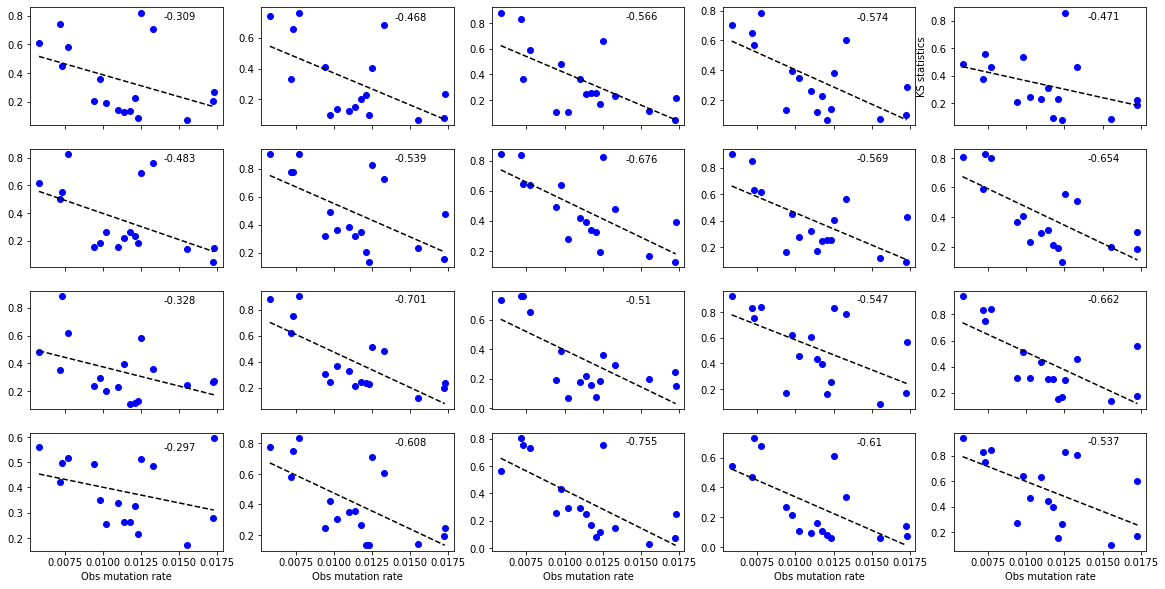

In [69]:
Arr_observed_mut = DF_observed_mut.values.flatten()

plt.figure(figsize=[20, 10])
for i in range(len(DF_KSstat)):
    plt.subplot(4, 5, i+1)
    poly1d_fn = np.poly1d(np.polyfit(Arr_observed_mut, DF_KSstat[i], 1)) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.plot(Arr_observed_mut, DF_KSstat[i], 'bo', 
             np.sort(Arr_observed_mut), poly1d_fn(np.sort(Arr_observed_mut)), '--k')
    #plt.scatter(x=Arr_observed_mut, y=DF_KSstat[i])
    if i == 4:
        plt.ylabel("KS statistics")
        plt.tick_params(labelbottom=False)
    elif i >= 15:
        plt.xlabel("Obs mutation rate")
    else:
        plt.tick_params(labelbottom=False)
        plt.ylabel("")
        plt.xlabel("")
    plt.annotate(round(spearmanr(Arr_observed_mut, DF_KSstat[i])[0], 3), 
                 xy=(0.014, max(DF_KSstat[i])-0.05))
plt.show()

### CTCF

Also generate a few plots for CTCF which is part of the pilot analysis:

In [6]:
TF_logo = pd.read_csv("data_input/TF_1kg/CTCF_known1/CTCF_known1_logo.txt", sep=" ", header=None, skiprows=[0])
TF_logo.pop(0)
TF_logo.columns = ["A", "C", "G", "T"]
display(TF_logo)

A         C         G         T
0   0.095290  0.318729  0.083242  0.502738
1   0.182913  0.158817  0.453450  0.204819
2   0.307777  0.053669  0.491785  0.146769
3   0.061336  0.876232  0.023001  0.039430
4   0.008762  0.989047  0.000000  0.002191
5   0.814896  0.014239  0.071194  0.099671
6   0.043812  0.578313  0.365827  0.012048
7   0.117325  0.474781  0.052632  0.355263
8   0.933114  0.012061  0.035088  0.019737
9   0.005488  0.000000  0.991218  0.003293
10  0.365532  0.003293  0.621295  0.009879
11  0.059276  0.013172  0.553238  0.374314
12  0.013187  0.000000  0.978022  0.008791
13  0.061538  0.008791  0.851648  0.078022
14  0.114411  0.806381  0.005501  0.073707
15  0.409241  0.014301  0.557756  0.018702
16  0.090308  0.530837  0.338106  0.040749
17  0.128855  0.354626  0.080396  0.436123
18  0.442731  0.199339  0.292952  0.064978

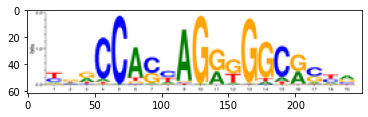

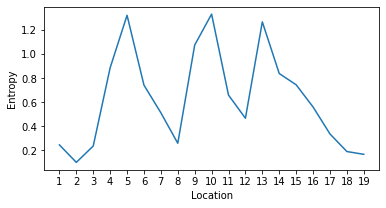

In [7]:
TF_conserve = entropy(TF_logo, qk=np.full(np.shape(TF_logo), fill_value=0.25), axis=1)

plt.figure(figsize=[6, 3])
plt.imshow(matplotlib.image.imread("data_input/TF_1kg/CTCF_known1/CTCF_known1.png"))
plt.show()

fig_out = plt.figure(figsize=[6, 3])
plt.plot(TF_conserve)
plt.xlabel("Location")
plt.ylabel("Entropy")
plt.xticks(np.arange(0, len(TF_logo)), np.arange(1, len(TF_logo)+1))
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5a_entropy_ctcf.pdf", dpi=300)

In [8]:
# TFBS shape distribution
DF_pos_shape = pd.read_csv("data_input/TF_1kg/CTCF_known1/shape_CTCF_known1.csv")
# TFBS mutation ref and alt distribution
DF_pos_muts = pd.read_csv("data_input/TF_1kg/CTCF_known1/mutdists_CTCF_known1.bed", 
                          sep="\t", index_col=None, header=None)
DF_pos_muts.columns = ["chr", "start", "end", "mut", "MAF", "pos", "kmer_xtend", "kmer"]
# 5-mer reference DF
DF_strucval_5mersheet = pd.read_csv("data_input/ref_5mers_structure.csv", index_col=0)

In [9]:
temp_altks = [0] * len(DF_pos_muts)
temp_alt7 = [0] * len(DF_pos_muts)
for i in range(len(temp_altks)):
    temp_kmer, temp_7mer = DF_pos_muts['kmer'][i].upper(), DF_pos_muts['kmer_xtend'][i].upper()
    temp_alt = DF_pos_muts['mut'][i].split(">")[1]
    temp_altks[i] = temp_kmer[0:2] + temp_alt + temp_kmer[3:5]
    temp_alt7[i] = temp_7mer[0:3] + temp_alt + temp_7mer[4:7]
DF_pos_muts['kmer_alt'] = temp_altks
DF_pos_muts['kmer_alt_xtend'] = temp_alt7

In [10]:
DF_pos_muts.index = [item.upper() for item in DF_pos_muts['kmer'].values]
DF_pos_muts_ref = DF_pos_muts.join(DF_strucval_5mersheet, how="left")
DF_pos_muts_ref.sort_values(by=["pos", "kmer"], inplace=True)
DF_pos_muts.index = DF_pos_muts['kmer_alt']
DF_pos_muts_alt = DF_pos_muts.join(DF_strucval_5mersheet, how="left")
DF_pos_muts_alt.sort_values(by=["pos", "kmer"], inplace=True)

In [11]:
shape_picks = np.arange(np.shape(DF_strucval_5mersheet)[1])
DF_KSstat = np.zeros(shape=(len(shape_picks), max(DF_pos_muts_ref['pos'])+1))
Shape_types = []

j = 0
for i in shape_picks:
    Shape_types.append(DF_pos_muts_ref.columns[10+i])
    for pos_select in range(max(DF_pos_muts_ref['pos'])+1):
        # Temporary calculations
        temp_refval = DF_pos_muts_ref[DF_pos_muts_ref['pos'] == pos_select].iloc[:, 10+i].values
        temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
        colname_shape = DF_pos_muts_ref.columns[10+i]
        colname_shape = colname_shape.split("_")[0] + "_" + str(int(colname_shape.split("_")[1]) + pos_select)
        if colname_shape not in DF_pos_shape.columns:
            continue
        temp_bgval = DF_pos_shape[colname_shape]
        # Add to arrays
        DF_KSstat[j, pos_select] = kstest(temp_bgval, temp_altval)[0]
    j += 1

In [12]:
temp_helt1_df, temp_helt2_df = pd.DataFrame({"value": [], "type": [], "pos": []}), \
                               pd.DataFrame({"value": [], "type": [], "pos": []})

for pos_select in range(max(DF_pos_muts_ref['pos'])+1):
    i = 0
    temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
    colname_shape = DF_pos_muts_ref.columns[10+i]
    colname_shape = "HelT_" + str(int(colname_shape.split("_")[1]) + pos_select)
    if colname_shape not in DF_pos_shape.columns:
        continue
    temp_bgval = DF_pos_shape[colname_shape]
    temp_helt1_df = temp_helt1_df.append(pd.DataFrame({"value": temp_bgval, "type": "background", "pos": int(pos_select)}))
    temp_helt1_df = temp_helt1_df.append(pd.DataFrame({"value": temp_altval, "type": "mutated", "pos": int(pos_select)}))
    
    i = 1
    temp_altval = DF_pos_muts_alt[DF_pos_muts_alt['pos'] == pos_select].iloc[:, 10+i].values
    colname_shape = DF_pos_muts_ref.columns[10+i]
    colname_shape = "HelT_" + str(int(colname_shape.split("_")[1]) + pos_select)
    if colname_shape not in DF_pos_shape.columns:
        continue
    temp_bgval = DF_pos_shape[colname_shape]
    temp_helt2_df = temp_helt2_df.append(pd.DataFrame({"value": temp_bgval, "type": "background", "pos": int(pos_select)}))
    temp_helt2_df = temp_helt2_df.append(pd.DataFrame({"value": temp_altval, "type": "mutated", "pos": int(pos_select)}))

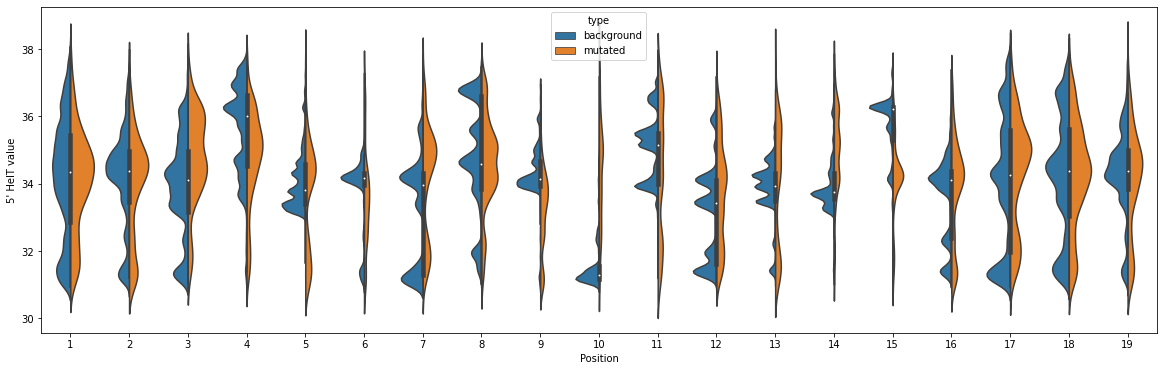

In [13]:
fig_out = plt.figure(figsize=[20, 6])
sns.violinplot(x="pos", y="value", hue="type", data=temp_helt1_df, split=True)
plt.xticks(np.arange(19), np.arange(1, 20, 1))
plt.xlabel("Position")
plt.ylabel("5' HelT value")
fig_out.savefig("manuscript/figures/pltout_fig5b_shapedist_ctcf.pdf", dpi=300)

In [14]:
DF_observed_mut = pd.DataFrame([Counter(DF_pos_muts_ref['pos'])]).transpose()
DF_observed_mut.sort_index(inplace=True)
DF_observed_mut = DF_observed_mut / len(DF_pos_shape)

KS stats vs observed mutation rates, first look at all features, then do this for HelT, Roll, Shift, Tilt, Stretch, and the most correlative feature:

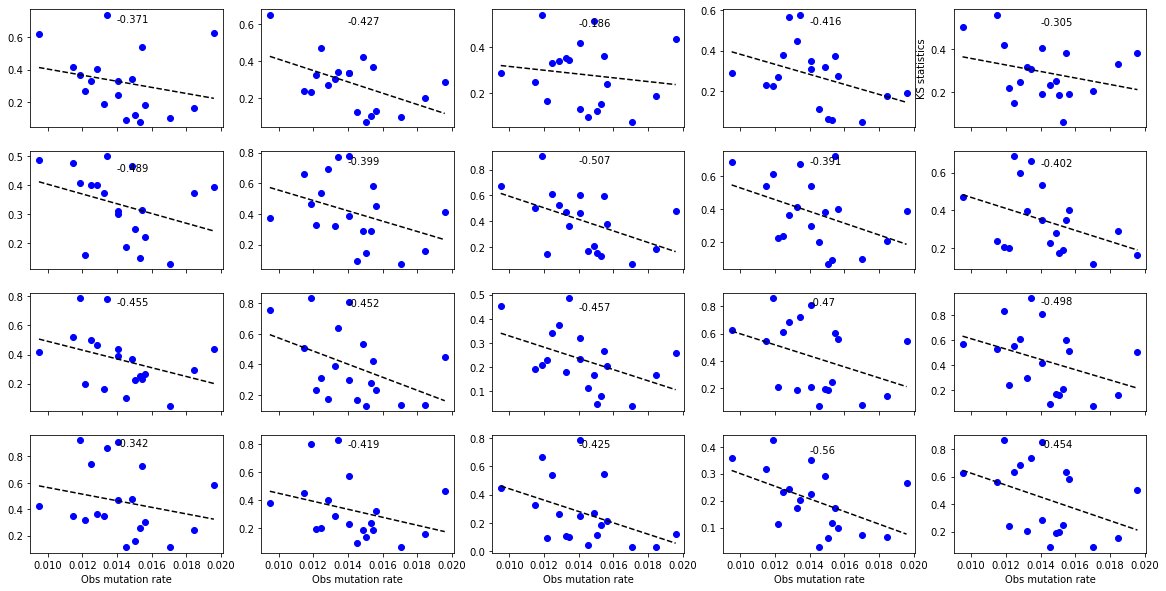

In [15]:
Arr_observed_mut = DF_observed_mut.values.flatten()

plt.figure(figsize=[20, 10])
for i in range(len(DF_KSstat)):
    plt.subplot(4, 5, i+1)
    poly1d_fn = np.poly1d(np.polyfit(Arr_observed_mut, DF_KSstat[i], 1)) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.plot(Arr_observed_mut, DF_KSstat[i], 'bo', 
             np.sort(Arr_observed_mut), poly1d_fn(np.sort(Arr_observed_mut)), '--k')
    #plt.scatter(x=Arr_observed_mut, y=DF_KSstat[i])
    if i == 4:
        plt.ylabel("KS statistics")
        plt.tick_params(labelbottom=False)
    elif i >= 15:
        plt.xlabel("Obs mutation rate")
    else:
        plt.tick_params(labelbottom=False)
        plt.ylabel("")
        plt.xlabel("")
    plt.annotate(round(spearmanr(Arr_observed_mut, DF_KSstat[i])[0], 3), 
                 xy=(0.014, max(DF_KSstat[i])-0.05))
plt.show()

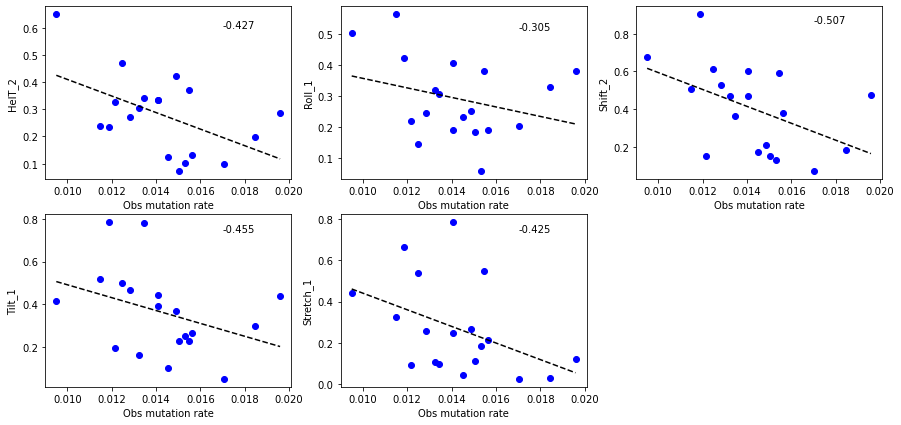

In [19]:
Arr_observed_mut = DF_observed_mut.values.flatten()
temp_shape_annots = [1, 4, 7, 10, 17]

fig_out = plt.figure(figsize=[15, 7])
for j in range(len(temp_shape_annots)):
    plt.subplot(2, 3, j+1)
    i = temp_shape_annots[j]
    poly1d_fn = np.poly1d(np.polyfit(Arr_observed_mut, DF_KSstat[i], 1)) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.plot(Arr_observed_mut, DF_KSstat[i], 'bo', 
             np.sort(Arr_observed_mut), poly1d_fn(np.sort(Arr_observed_mut)), '--k')
    plt.ylabel(DF_strucval_5mersheet.columns[i])
    plt.xlabel("Obs mutation rate")
    plt.annotate(round(spearmanr(Arr_observed_mut, DF_KSstat[i])[0], 3), 
                 xy=(0.017, max(DF_KSstat[i])-0.05))
plt.show()

fig_out.savefig("manuscript/figures/pltout_fig5c_scatterctcf.pdf", dpi=300)

### All TFBS analysis

Do the rest of the TF analyses on cluster... then reload the files:

In [15]:
with pd.ExcelFile("data_input/TF_1kg/tfbs_shapemutrate.xlsx") as f:
    DF_KSvmutrate = f.parse(sheet_name="KS_mutrate", index_col=0)
    DF_KSvconserve = f.parse(sheet_name="KS_conserve", index_col=0)
    DF_mutratevconserve = f.parse(sheet_name="conserve_mutrate", index_col=0)
    
temp_index = [item.strip("ummary_") for item in DF_KSvmutrate.index]
DF_KSvmutrate.index = temp_index
DF_KSvconserve.index = temp_index
DF_mutratevconserve.index = temp_index

In [16]:
display(DF_KSvmutrate)
display(DF_KSvconserve)
display(DF_mutratevconserve)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
TFAP2B_4      -0.010989  0.126374 -0.082418 -0.159341 -0.076923 -0.186813   
TFAP2E_1       0.396429  0.325000  0.417857  0.364286  0.250000  0.128571   
TFAP2_known1   0.994654  0.992053  0.996713  0.995015  0.995123  0.994112   
TFAP2_known10  0.417857  0.460714  0.600000  0.296429  0.510714  0.439286   
TFAP2_known11 -0.265734 -0.146853 -0.027972  0.006993  0.055944 -0.475524   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2        -0.145028  0.057319 -0.378919 -0.145413 -0.258127 -0.243893   
AIRE_1         0.504274  0.183590  0.250598  0.241709  0.477607  0.108376   
AHR_2          0.154545  0.036364  0.363636  0.127273 -0.400000 -0.054545   
AHR_1          0.157895  0.062951  0.192982  0.009288  0.034056 -0.139319   
AFP_1         -0.081818 -0.209091 -0.536364 -0.445455 -0.381818 -0.354545   

                Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
TFAP2B_4      -0.093407 -0.142857 -0.087912 -0.093407 -0.247253 -0.291209   
TFAP2E_1       0.635714  0.525000  0.446429  0.317857  0.607143  0.403571   
TFAP2_known1   0.994148  0.994582  0.994220  0.993787  0.996641  0.994762   
TFAP2_known10  0.425000  0.425000  0.442857  0.357143  0.646429  0.467857   
TFAP2_known11 -0.377622 -0.153846 -0.209790 -0.188811  0.020979 -0.230769   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2        -0.150414 -0.512406 -0.628582 -0.351221 -0.493172 -0.195807   
AIRE_1         0.200000  0.601368  0.167863  0.046838  0.280684  0.325128   
AHR_2         -0.264238  0.209568  0.036364 -0.281818 -0.309091  0.463636   
AHR_1         -0.207430  0.188854  0.157895 -0.147575 -0.304438  0.085655   
AFP_1         -0.490909 -0.409091 -0.445455 -0.790909 -0.427273 -0.545455   

               Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
TFAP2B_4      -0.181319  -0.131868 -0.291209 -0.087912  -0.263736   0.137363   
TFAP2E_1       0.207143   0.578571  0.382143  0.471429   0.428571   0.446429   
TFAP2_known1   0.994870   0.995412  0.994184  0.992848   0.995701   0.992667   
TFAP2_known10  0.303571   0.457143  0.228571  0.371429   0.307143   0.535714   
TFAP2_known11 -0.069930  -0.090909 -0.272727 -0.286713  -0.118881  -0.034965   
...                 ...        ...       ...       ...        ...        ...   
AIRE_2         0.023851  -0.468167 -0.439315 -0.135026  -0.495480  -0.247740   
AIRE_1         0.519316   0.303248  0.163761  0.302564   0.185641   0.068718   
AHR_2         -0.100000   0.072893  0.136364  0.463636   0.654545   0.418182   
AHR_1         -0.176471   0.073271  0.145511  0.164087   0.131063   0.267286   
AFP_1         -0.372727  -0.545455 -0.609091 -0.272727  -0.781818  -0.609091   

                  MGW_1      EP_1  
TFAP2B_4      -0.203297 -0.131868  
TFAP2E_1       0.375000  0.628571  
TFAP2_known1   0.994979  0.994184  
TFAP2_known10  0.432143  0.507143  
TFAP2_known11 -0.216783 -0.188811  
...                 ...       ...  
AIRE_2        -0.289286 -0.470475  
AIRE_1         0.537778  0.303932  
AHR_2          0.209091  0.350798  
AHR_1          0.215686 -0.023736  
AFP_1         -0.318182 -0.372727  

[1630 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
TFAP2B_4       0.858022  0.910952  0.735447  0.582229  0.799520  0.693661   
TFAP2E_1       0.839752  0.800361  0.739483  0.836171  0.410028  0.608776   
TFAP2_known1        NaN       NaN       NaN       NaN       NaN       NaN   
TFAP2_known10  0.743732  0.774199  0.510756  0.863805  0.440863  0.516132   
TFAP2_known11  0.664336  0.790210  0.699301  0.426573  0.286713  0.594406   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2         0.335729  0.331469  0.394588  0.433698  0.551804  0.314044   
AIRE_1         0.651245  0.602230  0.432221  0.567611  0.607371  0.503172   
AHR_2          0.753235  0.705562  0.629285  0.686493  0.743701  0.657889   
AHR_1          0.322343  0.553039  0.278100  0.668914  0.628885  0.660487   
AFP_1          0.456080  0.573778  0.362902  0.588490  0.000000  0.353094   

                Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
TFAP2B_4       0.846879  0.897023  0.858022  0.835736  0.632373  0.813449   
TFAP2E_1       0.889887  0.938231  0.864820  0.827219  0.680396  0.744855   
TFAP2_known1        NaN       NaN       NaN       NaN       NaN       NaN   
TFAP2_known10  0.835131  0.704306  0.747317  0.842299  0.686384  0.695345   
TFAP2_known11  0.818182  0.881119  0.685315  0.797203  0.454545  0.727273   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2         0.666037  0.477455  0.439119  0.467000  0.513081  0.458094   
AIRE_1         0.755101  0.592290  0.594346  0.531621  0.772582  0.652273   
AHR_2          0.754953  0.630720  0.610216  0.800909  0.781839  0.896255   
AHR_1          0.672074  0.544612  0.377120  0.698410  0.697356  0.685769   
AFP_1          0.681667  0.328574  0.745421  0.279533 -0.235396  0.593394   

               Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
TFAP2B_4       0.721518   0.816235  0.919309  0.963882   0.802306   0.774448   
TFAP2E_1       0.689349   0.811104  0.954345  0.993737   0.848705   0.803942   
TFAP2_known1        NaN        NaN       NaN       NaN        NaN        NaN   
TFAP2_known10  0.711474   0.672047  0.881726  0.926529   0.826170   0.754485   
TFAP2_known11  0.741259   0.671329  0.930070  0.909091   0.797203   0.699301   
...                 ...        ...       ...       ...        ...        ...   
AIRE_2         0.078608   0.669522  0.599433  0.720636   0.661777   0.599433   
AIRE_1         0.521338   0.893576  0.824681  0.912085   0.872325   0.826052   
AHR_2          0.829512   0.869630  0.934393  0.867651   0.572078   0.800909   
AHR_1          0.517223   0.829032  0.844833  0.873275   0.695249   0.629938   
AFP_1         -0.353094   0.539449  0.539449  0.750325   0.328574   0.353094   

                  MGW_1      EP_1  
TFAP2B_4       0.713161  0.874737  
TFAP2E_1       0.895258  0.884515  
TFAP2_known1        NaN       NaN  
TFAP2_known10  0.924737  0.802873  
TFAP2_known11  0.804196  0.755245  
...                 ...       ...  
AIRE_2         0.709794  0.685011  
AIRE_1         0.745161  0.893576  
AHR_2          0.791374  0.898299  
AHR_1          0.635205  0.763721  
AFP_1          0.024520  0.495312  

[1630 rows x 20 columns]

conserve_mutrate
TFAP2B_4              -0.144861
TFAP2E_1               0.494183
TFAP2_known1                NaN
TFAP2_known10          0.433695
TFAP2_known11         -0.370629
...                         ...
AIRE_2                -0.249037
AIRE_1                 0.226907
AHR_2                  0.104881
AHR_1                  0.027389
AFP_1                 -0.323669

[1630 rows x 1 columns]

Remove NaNs:

In [17]:
DF_KSvmutrate = DF_KSvmutrate.fillna(0)
DF_KSvconserve = DF_KSvconserve.fillna(0)
DF_mutratevconserve = DF_mutratevconserve.fillna(0)

Note that many of the motifs are "discovered"; what if we only looked at known motifs by removing the discs?

Also, perform better quality control by removing all-0/all-1 rows, as well as interaction TFs:

In [18]:
DF_KSvmutrate = DF_KSvmutrate[[not "disc" in item for item in DF_KSvmutrate.index]]
DF_KSvmutrate = DF_KSvmutrate[[not "::" in item for item in DF_KSvmutrate.index]]

DF_KSvconserve = DF_KSvconserve.loc[DF_KSvmutrate.index]
DF_mutratevconserve = DF_mutratevconserve.loc[DF_KSvmutrate.index]

drop_index = []
for item in DF_KSvconserve.index:
    if np.all(DF_KSvconserve.loc[item] == 0):
        drop_index.append(item)
    elif np.all(DF_KSvmutrate.loc[item] == 1):
        drop_index.append(item)
        
# Drop the bad indices
DF_KSvmutrate.drop(drop_index, inplace=True)
DF_KSvconserve.drop(drop_index, inplace=True)
DF_mutratevconserve.drop(drop_index, inplace=True)

In [19]:
display(DF_KSvmutrate)
display(DF_KSvconserve)
display(DF_mutratevconserve)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
TFAP2B_4      -0.010989  0.126374 -0.082418 -0.159341 -0.076923 -0.186813   
TFAP2E_1       0.396429  0.325000  0.417857  0.364286  0.250000  0.128571   
TFAP2_known10  0.417857  0.460714  0.600000  0.296429  0.510714  0.439286   
TFAP2_known11 -0.265734 -0.146853 -0.027972  0.006993  0.055944 -0.475524   
TFAP2_known12  0.041002  0.287017  0.100228 -0.277905 -0.378133 -0.355354   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2        -0.145028  0.057319 -0.378919 -0.145413 -0.258127 -0.243893   
AIRE_1         0.504274  0.183590  0.250598  0.241709  0.477607  0.108376   
AHR_2          0.154545  0.036364  0.363636  0.127273 -0.400000 -0.054545   
AHR_1          0.157895  0.062951  0.192982  0.009288  0.034056 -0.139319   
AFP_1         -0.081818 -0.209091 -0.536364 -0.445455 -0.381818 -0.354545   

                Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
TFAP2B_4      -0.093407 -0.142857 -0.087912 -0.093407 -0.247253 -0.291209   
TFAP2E_1       0.635714  0.525000  0.446429  0.317857  0.607143  0.403571   
TFAP2_known10  0.425000  0.425000  0.442857  0.357143  0.646429  0.467857   
TFAP2_known11 -0.377622 -0.153846 -0.209790 -0.188811  0.020979 -0.230769   
TFAP2_known12  0.091116  0.287017 -0.291573 -0.118451  0.000000 -0.095672   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2        -0.150414 -0.512406 -0.628582 -0.351221 -0.493172 -0.195807   
AIRE_1         0.200000  0.601368  0.167863  0.046838  0.280684  0.325128   
AHR_2         -0.264238  0.209568  0.036364 -0.281818 -0.309091  0.463636   
AHR_1         -0.207430  0.188854  0.157895 -0.147575 -0.304438  0.085655   
AFP_1         -0.490909 -0.409091 -0.445455 -0.790909 -0.427273 -0.545455   

               Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
TFAP2B_4      -0.181319  -0.131868 -0.291209 -0.087912  -0.263736   0.137363   
TFAP2E_1       0.207143   0.578571  0.382143  0.471429   0.428571   0.446429   
TFAP2_known10  0.303571   0.457143  0.228571  0.371429   0.307143   0.535714   
TFAP2_known11 -0.069930  -0.090909 -0.272727 -0.286713  -0.118881  -0.034965   
TFAP2_known12 -0.478361   0.414580  0.255126  0.364466  -0.041002   0.077449   
...                 ...        ...       ...       ...        ...        ...   
AIRE_2         0.023851  -0.468167 -0.439315 -0.135026  -0.495480  -0.247740   
AIRE_1         0.519316   0.303248  0.163761  0.302564   0.185641   0.068718   
AHR_2         -0.100000   0.072893  0.136364  0.463636   0.654545   0.418182   
AHR_1         -0.176471   0.073271  0.145511  0.164087   0.131063   0.267286   
AFP_1         -0.372727  -0.545455 -0.609091 -0.272727  -0.781818  -0.609091   

                  MGW_1      EP_1  
TFAP2B_4      -0.203297 -0.131868  
TFAP2E_1       0.375000  0.628571  
TFAP2_known10  0.432143  0.507143  
TFAP2_known11 -0.216783 -0.188811  
TFAP2_known12 -0.605924  0.287017  
...                 ...       ...  
AIRE_2        -0.289286 -0.470475  
AIRE_1         0.537778  0.303932  
AHR_2          0.209091  0.350798  
AHR_1          0.215686 -0.023736  
AFP_1         -0.318182 -0.372727  

[1600 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
TFAP2B_4       0.858022  0.910952  0.735447  0.582229  0.799520  0.693661   
TFAP2E_1       0.839752  0.800361  0.739483  0.836171  0.410028  0.608776   
TFAP2_known10  0.743732  0.774199  0.510756  0.863805  0.440863  0.516132   
TFAP2_known11  0.664336  0.790210  0.699301  0.426573  0.286713  0.594406   
TFAP2_known12  0.709091  0.690909  0.836364  0.454545  0.245455  0.381818   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2         0.335729  0.331469  0.394588  0.433698  0.551804  0.314044   
AIRE_1         0.651245  0.602230  0.432221  0.567611  0.607371  0.503172   
AHR_2          0.753235  0.705562  0.629285  0.686493  0.743701  0.657889   
AHR_1          0.322343  0.553039  0.278100  0.668914  0.628885  0.660487   
AFP_1          0.456080  0.573778  0.362902  0.588490  0.000000  0.353094   

                Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
TFAP2B_4       0.846879  0.897023  0.858022  0.835736  0.632373  0.813449   
TFAP2E_1       0.889887  0.938231  0.864820  0.827219  0.680396  0.744855   
TFAP2_known10  0.835131  0.704306  0.747317  0.842299  0.686384  0.695345   
TFAP2_known11  0.818182  0.881119  0.685315  0.797203  0.454545  0.727273   
TFAP2_known12  0.881818  0.709091  0.609091  0.609091  0.281818  0.136364   
...                 ...       ...       ...       ...       ...       ...   
AIRE_2         0.666037  0.477455  0.439119  0.467000  0.513081  0.458094   
AIRE_1         0.755101  0.592290  0.594346  0.531621  0.772582  0.652273   
AHR_2          0.754953  0.630720  0.610216  0.800909  0.781839  0.896255   
AHR_1          0.672074  0.544612  0.377120  0.698410  0.697356  0.685769   
AFP_1          0.681667  0.328574  0.745421  0.279533 -0.235396  0.593394   

               Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
TFAP2B_4       0.721518   0.816235  0.919309  0.963882   0.802306   0.774448   
TFAP2E_1       0.689349   0.811104  0.954345  0.993737   0.848705   0.803942   
TFAP2_known10  0.711474   0.672047  0.881726  0.926529   0.826170   0.754485   
TFAP2_known11  0.741259   0.671329  0.930070  0.909091   0.797203   0.699301   
TFAP2_known12  0.481818   0.663636  0.709091  0.890909   0.336364   0.690909   
...                 ...        ...       ...       ...        ...        ...   
AIRE_2         0.078608   0.669522  0.599433  0.720636   0.661777   0.599433   
AIRE_1         0.521338   0.893576  0.824681  0.912085   0.872325   0.826052   
AHR_2          0.829512   0.869630  0.934393  0.867651   0.572078   0.800909   
AHR_1          0.517223   0.829032  0.844833  0.873275   0.695249   0.629938   
AFP_1         -0.353094   0.539449  0.539449  0.750325   0.328574   0.353094   

                  MGW_1      EP_1  
TFAP2B_4       0.713161  0.874737  
TFAP2E_1       0.895258  0.884515  
TFAP2_known10  0.924737  0.802873  
TFAP2_known11  0.804196  0.755245  
TFAP2_known12  0.472727  0.545455  
...                 ...       ...  
AIRE_2         0.709794  0.685011  
AIRE_1         0.745161  0.893576  
AHR_2          0.791374  0.898299  
AHR_1          0.635205  0.763721  
AFP_1          0.024520  0.495312  

[1600 rows x 20 columns]

conserve_mutrate
TFAP2B_4              -0.144861
TFAP2E_1               0.494183
TFAP2_known10          0.433695
TFAP2_known11         -0.370629
TFAP2_known12          0.214124
...                         ...
AIRE_2                -0.249037
AIRE_1                 0.226907
AHR_2                  0.104881
AHR_1                  0.027389
AFP_1                 -0.323669

[1600 rows x 1 columns]

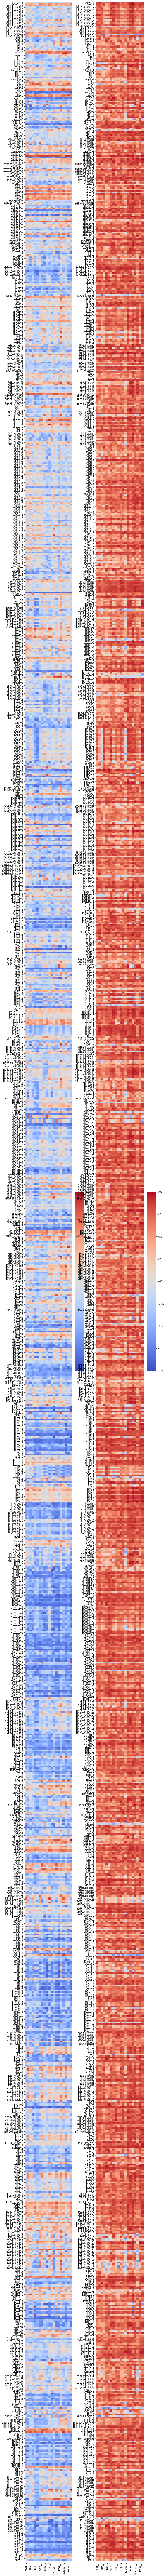

In [20]:
temp_fig = plt.figure(figsize=[10, 200])
plt.subplot(121)
sns.heatmap(DF_KSvmutrate, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate))+0.5, DF_KSvmutrate.index)
plt.subplot(122)
sns.heatmap(DF_KSvconserve, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvconserve))+0.5, DF_KSvconserve.index)
plt.show()

Save tables to xlsx:

In [11]:
with pd.ExcelWriter("data_out/Results_corrcoef_tfbs_all.xlsx") as writer:
    DF_KSvmutrate.to_excel(writer, sheet_name="shapechange_v_mutrate")
    DF_KSvconserve.to_excel(writer, sheet_name="shapechange_v_entropy")

Also compare how many binding sites do each of the TFBSs have:

In [21]:
DF_bindingcount = pd.read_csv("data_input/TF_1kg/binding_count.txt", sep=" ", header=None)
DF_bindingcount.index = ["_".join(item.strip(".bed").split("_")[1:]) for item in DF_bindingcount.iloc[:, 1]]
DF_bindingcount.drop(drop_index, inplace=True)

display(DF_bindingcount)

0                               1
AFP_1       97171      motifbeds/motifs_AFP_1.bed
AHR_1        9748      motifbeds/motifs_AHR_1.bed
AHR_2        4734      motifbeds/motifs_AHR_2.bed
AIRE_1     108997     motifbeds/motifs_AIRE_1.bed
AIRE_2      62407     motifbeds/motifs_AIRE_2.bed
...           ...                             ...
ZNF8_1       2467     motifbeds/motifs_ZNF8_1.bed
ZSCAN16_1   53152  motifbeds/motifs_ZSCAN16_1.bed
ZSCAN26_1   77308  motifbeds/motifs_ZSCAN26_1.bed
ZSCAN4_1    73615   motifbeds/motifs_ZSCAN4_1.bed
ZSCAN4_2    81083   motifbeds/motifs_ZSCAN4_2.bed

[1604 rows x 2 columns]

[   736.    30388.5   52713.    96676.75 956165.  ]


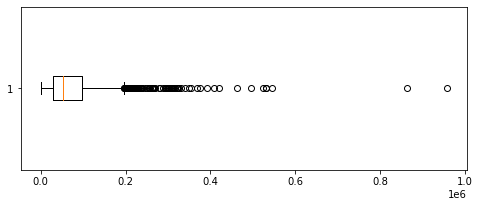

In [10]:
np.set_printoptions(suppress=True)
print(np.percentile(DF_bindingcount[0], [0, 25, 50, 75, 100]))

plt.figure(figsize=[8, 3])
plt.boxplot(DF_bindingcount[0], vert=False)
plt.show()

Compare ratios between least/most mutable positions for each TF:

In [22]:
DF_mutratio = pd.read_csv("data_input/TF_1kg/mutrate_ratio_tf.txt", sep=" ", header=None)
DF_mutratio.index = ["_".join(item.strip(".csv").split("_")[1:]) for item in DF_mutratio.iloc[:, 0]]
DF_mutratio.drop(drop_index, inplace=True)

display(DF_mutratio)

0          1
AFP_1          motifshapes/shape_AFP_1.csv   3.625000
AHR_1          motifshapes/shape_AHR_1.csv   7.788235
AHR_2          motifshapes/shape_AHR_2.csv  25.586207
AIRE_1        motifshapes/shape_AIRE_1.csv   2.144144
AIRE_2        motifshapes/shape_AIRE_2.csv   2.556793
...                                    ...        ...
ZNF8_1        motifshapes/shape_ZNF8_1.csv  19.894737
ZSCAN16_1  motifshapes/shape_ZSCAN16_1.csv   2.885196
ZSCAN26_1  motifshapes/shape_ZSCAN26_1.csv   2.337386
ZSCAN4_1    motifshapes/shape_ZSCAN4_1.csv   1.763285
ZSCAN4_2    motifshapes/shape_ZSCAN4_2.csv   1.681720

[1601 rows x 2 columns]

[ 1.24929178  2.23751328  2.84333333  4.14622642 10.59813084 46.15384615]


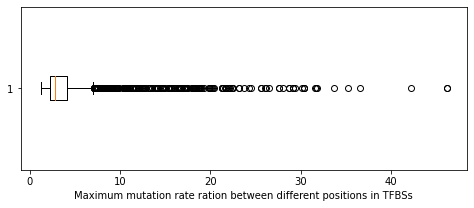

In [24]:
np.set_printoptions(suppress=True)
print(np.percentile(DF_mutratio[1], [0, 25, 50, 75, 90, 100]))

fig_out = plt.figure(figsize=[8, 3])
plt.boxplot(DF_mutratio[1], vert=False)
plt.xlabel("Maximum mutation rate ration between different positions in TFBSs")
plt.show()
fig_out.savefig("manuscript/figures/pltout_sup_tfmutrate_ratio.pdf")

Look closer at the TFBS KS values vs shape changes; what if we concatenate them by TF? 

Average by TF; before doing so, 1) remove "discovered" motifs, 2) remove low-quality statistics (all-1/all-0), 3) remove interactions (:: in naming)

In [25]:
temp_tfbs = np.unique([item.split("_")[0] for item in DF_KSvmutrate.index if ":" not in item])

DF_KSvmutrate_bytf, DF_KSvconserve_bytf, DF_mutratevconserve_bytf = [], [], []
for item in temp_tfbs:
    DF_KSvmutrate_bytf.append(np.mean(DF_KSvmutrate.filter(like=item, axis=0), axis=0))
    DF_KSvconserve_bytf.append(np.mean(DF_KSvconserve.filter(like=item, axis=0), axis=0))
    DF_mutratevconserve_bytf.append(np.mean(DF_mutratevconserve.filter(like=item, axis=0), axis=0))
    
DF_KSvmutrate_bytf = pd.DataFrame(DF_KSvmutrate_bytf, index=temp_tfbs)
DF_KSvconserve_bytf = pd.DataFrame(DF_KSvconserve_bytf, index=temp_tfbs)
DF_mutratevconserve_bytf = pd.DataFrame(DF_mutratevconserve_bytf, index=temp_tfbs)
display(DF_KSvmutrate_bytf)
display(DF_KSvconserve_bytf)
display(DF_mutratevconserve_bytf)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
AFP     -0.081818 -0.209091 -0.536364 -0.445455 -0.381818 -0.354545 -0.490909   
AHR      0.156220  0.049658  0.278309  0.068280 -0.182972 -0.096932 -0.235834   
AIRE     0.179623  0.120454 -0.064160  0.048148  0.109740 -0.067758  0.024793   
ALX1    -0.541068 -0.500991 -0.461835 -0.390101 -0.628706 -0.599265 -0.615019   
ALX3    -0.402887 -0.537240 -0.491460 -0.496175 -0.696450 -0.559810 -0.581021   
...           ...       ...       ...       ...       ...       ...       ...   
ZNF784   0.066667  0.212121  0.381818  0.103030 -0.418182 -0.321212  0.442424   
ZNF8     0.173433  0.153753  0.292745  0.055351  0.004920 -0.002460  0.008610   
ZSCAN16 -0.223942 -0.339525 -0.275542 -0.358101 -0.252838 -0.250774 -0.273478   
ZSCAN26  0.270330  0.147253  0.358242 -0.015385  0.024176  0.006593 -0.002198   
ZSCAN4  -0.019567  0.012942  0.038669 -0.110305 -0.175240 -0.151975 -0.046550   

          Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  \
AFP     -0.409091 -0.445455 -0.790909 -0.427273 -0.545455 -0.372727   
AHR      0.199211  0.097129 -0.214697 -0.306764  0.274646 -0.138235   
AIRE     0.044481 -0.230360 -0.152192 -0.106244  0.064661  0.271583   
ALX1    -0.625844 -0.560973 -0.588356 -0.635302 -0.606111 -0.533820   
ALX3    -0.609997 -0.514109 -0.465933 -0.648711 -0.550501 -0.422782   
...           ...       ...       ...       ...       ...       ...   
ZNF784   0.139394 -0.175758  0.515152  0.563636  0.272727  0.248485   
ZNF8     0.242314  0.127922  0.214024  0.065191 -0.094712  0.134072   
ZSCAN16 -0.155831 -0.729618 -0.223942 -0.205366 -0.190918 -0.405573   
ZSCAN26  0.424176 -0.195604 -0.094505 -0.151648  0.230769  0.072527   
ZSCAN4   0.001241 -0.372043 -0.199770 -0.043500 -0.056972  0.010479   

         Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1  \
AFP      -0.545455 -0.609091 -0.272727  -0.781818  -0.609091 -0.318182   
AHR       0.073082  0.140937  0.313862   0.392804   0.342734  0.212389   
AIRE     -0.082460 -0.137777  0.083769  -0.154919  -0.089511  0.124246   
ALX1     -0.617978 -0.670387 -0.576710  -0.642203  -0.648804 -0.615112   
ALX3     -0.634648 -0.584438 -0.331575  -0.493865  -0.709491 -0.693814   
...            ...       ...       ...        ...        ...       ...   
ZNF784    0.248485  0.527273  0.656538   0.684848   0.103030 -0.018182   
ZNF8      0.218944  0.230014  0.399757   0.303815   0.221404  0.120542   
ZSCAN16  -0.401445 -0.477812  0.174407  -0.318885  -0.221878 -0.009288   
ZSCAN26   0.134066 -0.059341  0.538462   0.217582   0.296703  0.107692   
ZSCAN4   -0.077199 -0.339537  0.124452   0.015965  -0.030630 -0.217563   

             EP_1  
AFP     -0.372727  
AHR      0.163531  
AIRE    -0.083272  
ALX1    -0.618778  
ALX3    -0.617984  
...           ...  
ZNF784   0.345455  
ZNF8     0.188193  
ZSCAN16 -0.374613  
ZSCAN26  0.164835  
ZSCAN4  -0.024497  

[575 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
AFP      0.456080  0.573778  0.362902  0.588490  0.000000  0.353094  0.681667   
AHR      0.537789  0.629301  0.453693  0.677704  0.686293  0.659188  0.713514   
AIRE     0.493487  0.466850  0.413404  0.500655  0.579587  0.408608  0.710569   
ALX1     0.778266  0.727613  0.730191  0.683517  0.807842  0.830830  0.882779   
ALX3     0.757230  0.710396  0.738696  0.833076  0.776096  0.847119  0.869067   
...           ...       ...       ...       ...       ...       ...       ...   
ZNF784   0.418182  0.369697  0.757576  0.333333  0.151515  0.406061  0.466667   
ZNF8     0.889706  0.835784  0.784314  0.705882  0.759804  0.821078  0.818627   
ZSCAN16  0.683614  0.517443  0.436461  0.369151  0.621562  0.714113  0.715165   
ZSCAN26  0.780220  0.643956  0.863736  0.564835  0.547253  0.538462  0.846154   
ZSCAN4   0.789182  0.819267  0.778780  0.841981  0.856100  0.836442  0.893522   

          Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  \
AFP      0.328574  0.745421  0.279533 -0.235396  0.593394 -0.353094   
AHR      0.587666  0.493668  0.749659  0.739598  0.791012  0.673368   
AIRE     0.534873  0.516733  0.499311  0.642831  0.555183  0.299973   
ALX1     0.883361  0.810717  0.770329  0.746523  0.814192  0.668057   
ALX3     0.899688  0.769546  0.682269  0.690051  0.796253  0.437741   
...           ...       ...       ...       ...       ...       ...   
ZNF784   0.721212  0.490909  0.418182  0.442424  0.612121  0.854545   
ZNF8     0.899510  0.860294  0.892157  0.825980  0.786765  0.732843   
ZSCAN16  0.581597  0.466961  0.715165  0.627873  0.489047  0.413323   
ZSCAN26  0.894505  0.507692  0.718681  0.529670  0.701099  0.780220   
ZSCAN4   0.916849  0.713095  0.740072  0.849336  0.834003  0.827887   

         Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1  \
AFP       0.539449  0.539449  0.750325   0.328574   0.353094  0.024520   
AHR       0.849331  0.889613  0.870463   0.633663   0.715423  0.713290   
AIRE      0.781549  0.712057  0.816361   0.767051   0.712743  0.727477   
ALX1      0.896924  0.837342  0.884016   0.858534   0.678107  0.781910   
ALX3      0.893710  0.769156  0.623359   0.804129   0.690059  0.733671   
...            ...       ...       ...        ...        ...       ...   
ZNF784    0.793939  0.793939  0.778119   0.769697   0.309091  0.696970   
ZNF8      0.931373  0.931373  0.857843   0.875000   0.884804  0.933824   
ZSCAN16   0.669941  0.716217  0.887646   0.751975   0.628924  0.533219   
ZSCAN26   0.898901  0.749451  0.925275   0.868132   0.643956  0.578022   
ZSCAN4    0.902121  0.826634  0.949374   0.872025   0.873290  0.858552   

             EP_1  
AFP      0.495312  
AHR      0.831010  
AIRE     0.789294  
ALX1     0.869374  
ALX3     0.823483  
...           ...  
ZNF784   0.818182  
ZNF8     0.882353  
ZSCAN16  0.740406  
ZSCAN26  0.916484  
ZSCAN4   0.897810  

[575 rows x 20 columns]

conserve_mutrate
AFP             -0.323669
AHR              0.066135
AIRE            -0.011065
ALX1            -0.628830
ALX3            -0.599968
...                   ...
ZNF784           0.430303
ZNF8             0.099632
ZSCAN16         -0.034707
ZSCAN26          0.358242
ZSCAN4           0.007980

[575 rows x 1 columns]

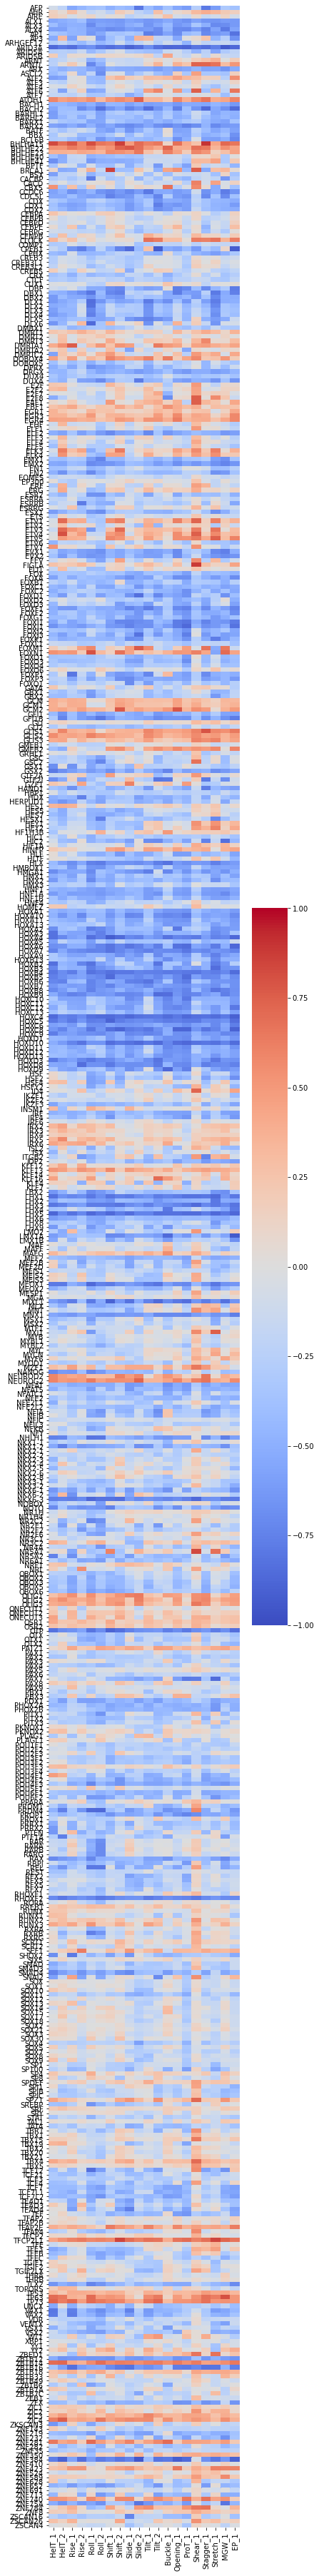

In [13]:
temp_plt = plt.figure(figsize=[6, 65])
sns.heatmap(DF_KSvmutrate_bytf, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_bytf))+0.5, DF_KSvmutrate_bytf.index)
plt.show()
temp_plt.savefig("data_out/heatmap_tfbs_correlations_bytf.pdf")

Save the tables:

In [13]:
with pd.ExcelWriter("data_out/Results_corrcoef_tfbs_all_bytf.xlsx") as writer:
    DF_KSvmutrate_bytf.to_excel(writer, sheet_name="shapechange_v_mutrate")
    DF_KSvconserve_bytf.to_excel(writer, sheet_name="shapechange_v_entropy")

How many motifs do we have per TF? 

[ 1.  1.  2.  4. 82.]


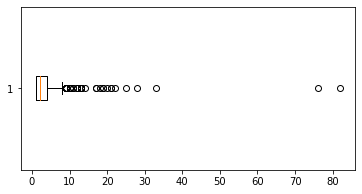

In [26]:
temp_tfbs = np.unique([item.split("_")[0] for item in DF_KSvmutrate.index if ":" not in item])
tf_motifcount = []

for item in temp_tfbs:
    tf_motifcount.append(len(DF_KSvmutrate.filter(like=item, axis=0)))

print(np.percentile(tf_motifcount, [0, 25, 50, 75, 100]))

plt.figure(figsize=[6, 3])
plt.boxplot(x=tf_motifcount, vert=False)
plt.show()

### VISTA

Use the ones intersecting with VISTA instead:

In [27]:
with pd.ExcelFile("data_input/TF_1kg/tfbs_shapemutrate_vista.xlsx") as f:
    DF_KSvmutrate_v = f.parse(sheet_name="KS_mutrate", index_col=0)
    DF_KSvconserve_v = f.parse(sheet_name="KS_conserve", index_col=0)
    DF_mutratevconserve_v = f.parse(sheet_name="conserve_mutrate", index_col=0)
    
temp_index = [item.strip("ummary_") for item in DF_KSvmutrate_v.index]
DF_KSvmutrate_v.index = temp_index
DF_KSvconserve_v.index = temp_index
DF_mutratevconserve_v.index = temp_index

Similar as above, change all NaNs to 0, then 1) remove all-1/all-0 rows, 2) remove discovered motifs, 3) remove interacting motifs

In [28]:
# Patch NaNs
DF_KSvmutrate_v = DF_KSvmutrate_v.fillna(0)
DF_KSvconserve_v = DF_KSvconserve_v.fillna(0)
DF_mutratevconserve_v = DF_mutratevconserve_v.fillna(0)

# Remove discovered and interacting motifs
DF_KSvmutrate_v = DF_KSvmutrate_v[[not "disc" in item for item in DF_KSvmutrate_v.index]]
DF_KSvmutrate_v = DF_KSvmutrate_v[[not "::" in item for item in DF_KSvmutrate_v.index]]
DF_KSvconserve_v = DF_KSvconserve_v.loc[DF_KSvmutrate_v.index]
DF_mutratevconserve_v = DF_mutratevconserve_v.loc[DF_KSvmutrate_v.index]

# Remove bad quality rows
drop_index = []
for item in DF_KSvconserve_v.index:
    if np.all(DF_KSvconserve_v.loc[item] == 0):
        drop_index.append(item)
    elif np.all(DF_KSvmutrate_v.loc[item] == 1):
        drop_index.append(item)
# Drop the bad indices
DF_KSvmutrate_v.drop(drop_index, inplace=True)
DF_KSvconserve_v.drop(drop_index, inplace=True)
DF_mutratevconserve_v.drop(drop_index, inplace=True)

# Display
display(DF_KSvmutrate_v)
display(DF_KSvconserve_v)
display(DF_mutratevconserve_v)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
ISX_4  -0.028127  0.032697 -0.070318  0.225018  0.032697  0.281272 -0.070318   
ISX_2  -0.170658 -0.358594 -0.187444 -0.338517 -0.268946 -0.414624 -0.265778   
ISL2_1 -0.540095 -0.319141 -0.191502 -0.088400  0.020946 -0.155825 -0.154099   
IRX6_1 -0.150469  0.044415 -0.111672 -0.194157  0.055235 -0.214461 -0.176391   
IRX5_1 -0.570463 -0.540812 -0.557439 -0.337537 -0.418353 -0.456590 -0.401395   
...          ...       ...       ...       ...       ...       ...       ...   
ALX1_4  0.288365 -0.155280 -0.260870 -0.186335 -0.320700 -0.262706 -0.322981   
ALX1_3  0.165000  0.317263  0.305380  0.289882  0.318829  0.332492  0.229095   
ALX1_1 -0.131151 -0.416148 -0.169788 -0.170898 -0.052184 -0.132057 -0.019985   
AIRE_1 -0.125222 -0.211193 -0.104446 -0.133147 -0.166433  0.127127  0.022302   
AFP_1  -0.126218 -0.304551 -0.196339 -0.028048 -0.117135  0.243086  0.299077   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
ISX_4   0.450035 -0.070318  0.032697  0.267208  0.112509 -0.291139   0.595341   
ISX_2  -0.330579 -0.271747 -0.238129 -0.377685 -0.344113 -0.302148  -0.257385   
ISL2_1  0.335622  0.181029 -0.272693 -0.323159  0.016481 -0.116782  -0.220252   
IRX6_1 -0.118017 -0.160627 -0.219537 -0.049491 -0.140859 -0.201771  -0.213192   
IRX5_1 -0.493620 -0.530412 -0.647812 -0.474510 -0.348408 -0.511897  -0.760618   
...          ...       ...       ...       ...       ...       ...        ...   
ALX1_4 -0.298137 -0.298137 -0.233856 -0.298137 -0.136646 -0.138467  -0.136646   
ALX1_3  0.319398  0.165000  0.342675  0.180003  0.294268  0.379447   0.220320   
ALX1_1  0.131151 -0.155442 -0.086738 -0.220395 -0.086048 -0.290748  -0.135527   
AIRE_1  0.052427 -0.097221 -0.077184  0.055577  0.116700 -0.057357   0.070517   
AFP_1  -0.110359  0.229584 -0.289834 -0.292505  0.093495 -0.150970  -0.070767   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
ISX_4   0.112509  0.032697   0.450035   0.225018  0.225018  0.112509  
ISX_2  -0.221016 -0.151074  -0.277350  -0.120300 -0.243397  0.123097  
ISL2_1 -0.167687 -0.011978  -0.068872  -0.059888  0.139005 -0.118367  
IRX6_1 -0.157356 -0.175973   0.039998  -0.101520 -0.121824  0.166976  
IRX5_1 -0.708957 -0.531399  -0.363601  -0.413156 -0.472490 -0.552911  
...          ...       ...        ...        ...       ...       ...  
ALX1_4 -0.198758 -0.335399  -0.149068  -0.236933 -0.166161 -0.136646  
ALX1_3  0.368025  0.283731   0.318733   0.180192  0.369025  0.347720  
ALX1_1 -0.148780 -0.024995   0.021085  -0.266334 -0.326428 -0.102306  
AIRE_1  0.067116  0.136050   0.008856   0.032567 -0.133478  0.154534  
AFP_1  -0.245327 -0.050360  -0.309236  -0.346719 -0.373979 -0.131580  

[479 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
ISX_4   0.027277 -0.139520 -0.163663  0.518267  0.304408  0.311740 -0.163663   
ISX_2   0.302198  0.206328  0.571429  0.010989  0.478680  0.330124  0.181319   
ISL2_1  0.179412  0.359352  0.476471  0.502210  0.523529  0.659795  0.550000   
IRX6_1  0.523634  0.593865  0.600000  0.142331  0.609577  0.358282  0.512884   
IRX5_1  0.456897  0.785496  0.724138  0.285890  0.642508  0.702953  0.713494   
...          ...       ...       ...       ...       ...       ...       ...   
ALX1_4 -0.018182 -0.300636  0.202469  0.263824  0.096976  0.212604  0.288365   
ALX1_3  0.307793  0.462061  0.453885  0.257159  0.368663  0.477006  0.484257   
ALX1_1  0.002592  0.072464  0.256730  0.244308  0.348007  0.216357  0.413777   
AIRE_1  0.043590  0.093654  0.299486 -0.131584  0.174473 -0.112541  0.350541   
AFP_1  -0.441367 -0.621781 -0.475696 -0.259916 -0.528391 -0.102986  0.010287   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
ISX_4   0.202631 -0.163663  0.304408  0.490990 -0.452023 -0.208687  -0.082479   
ISX_2   0.217332  0.393398  0.332875  0.230769  0.324176  0.148352   0.379121   
ISL2_1  0.497791  0.105882  0.403535  0.538235  0.471282  0.407653   0.465391   
IRX6_1  0.496933  0.499079  0.327608  0.579142  0.478528  0.525154   0.585277   
IRX5_1  0.552956  0.467118  0.215252  0.760911  0.485557  0.589682   0.774631   
...          ...       ...       ...       ...       ...       ...        ...   
ALX1_4  0.067490  0.153386  0.024316  0.153386  0.312907 -0.328269   0.239282   
ALX1_3  0.401150  0.116195  0.431941  0.369370  0.288794  0.425943   0.329006   
ALX1_1  0.511665  0.279131  0.362033  0.386330  0.496636 -0.145963   0.351296   
AIRE_1  0.214176  0.065203  0.175643  0.280570  0.332876 -0.065695   0.419228   
AFP_1  -0.448314 -0.368645 -0.426655 -0.767139 -0.152027 -0.608762  -0.153428   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
ISX_4  -0.452023 -0.139520   0.202631   0.518267  0.518267 -0.452023  
ISX_2   0.335165  0.192308   0.283357   0.307692  0.225275  0.032967  
ISL2_1  0.313466  0.607800   0.507726   0.219279  0.704586  0.371134  
IRX6_1  0.431902  0.374079   0.602210   0.472393  0.597546  0.389810  
IRX5_1  0.762785  0.729632   0.752927   0.524572  0.721231  0.685574  
...          ...       ...        ...        ...       ...       ...  
ALX1_4  0.128844  0.000000  -0.030677   0.279637 -0.340427  0.251553  
ALX1_3  0.509388  0.358011   0.387579   0.244566  0.519785  0.525579  
ALX1_1  0.315382  0.066321   0.638719   0.033126 -0.144485  0.346473  
AIRE_1  0.353810  0.454171   0.097821   0.274396  0.092281  0.484958  
AFP_1  -0.628559 -0.561010  -0.621781  -0.555425 -0.701284 -0.238426  

[479 rows x 20 columns]

conserve_mutrate
ISX_4           0.110481
ISX_2          -0.573521
ISL2_1          0.100239
IRX6_1         -0.118162
IRX5_1         -0.411567
...                  ...
ALX1_4         -0.570595
ALX1_3         -0.005007
ALX1_1          0.182561
AIRE_1         -0.123422
AFP_1           0.335397

[479 rows x 1 columns]

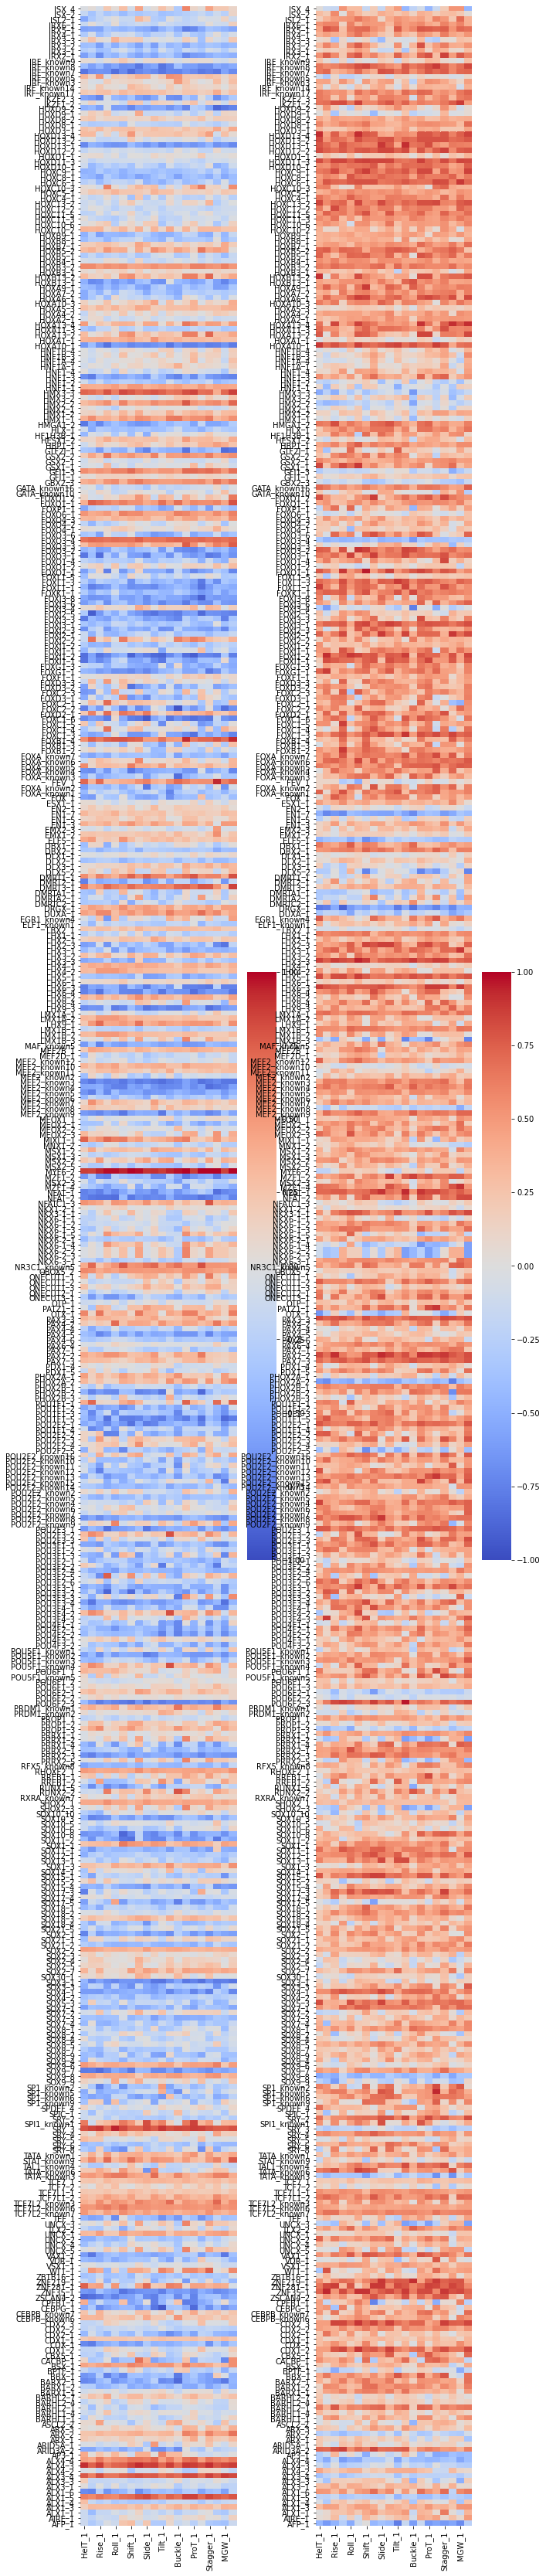

In [16]:
temp_fig = plt.figure(figsize=[10, 60])
plt.subplot(121)
sns.heatmap(DF_KSvmutrate_v, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_v))+0.5, DF_KSvmutrate_v.index)
plt.subplot(122)
sns.heatmap(DF_KSvconserve_v, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvconserve_v))+0.5, DF_KSvconserve_v.index)
plt.show()
temp_fig.savefig("data_out/heatmap_tfbs_correlations_vista.pdf")

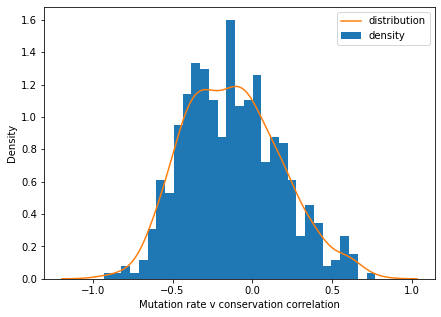

In [17]:
plt.figure(figsize=[7, 5])
plt.hist(DF_mutratevconserve_v, bins=31, density=True)
sns.kdeplot(x=DF_mutratevconserve_v.values.flatten())
plt.legend(["distribution", "density"])
plt.xlabel("Mutation rate v conservation correlation")
plt.show()

Aggregate by TF:

In [29]:
temp_tfbs = np.unique([item.split("_")[0] for item in DF_KSvmutrate_v.index if ":" not in item])

DF_KSvmutrate_v_bytf, DF_KSvconserve_v_bytf = [], []
for item in temp_tfbs:
    DF_KSvmutrate_v_bytf.append(np.mean(DF_KSvmutrate_v.filter(like=item, axis=0), axis=0))
    DF_KSvconserve_v_bytf.append(np.mean(DF_KSvconserve_v.filter(like=item, axis=0), axis=0))

DF_KSvmutrate_v_bytf = pd.DataFrame(DF_KSvmutrate_v_bytf, index=temp_tfbs)
DF_KSvconserve_v_bytf = pd.DataFrame(DF_KSvconserve_v_bytf, index=temp_tfbs)
display(DF_KSvmutrate_v_bytf)
display(DF_KSvconserve_v_bytf)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
AFP    -0.126218 -0.304551 -0.196339 -0.028048 -0.117135  0.243086  0.299077   
AIRE   -0.125222 -0.211193 -0.104446 -0.133147 -0.166433  0.127127  0.022302   
ALX1    0.048394 -0.082596  0.056020 -0.024540  0.001960  0.036120  0.069252   
ALX3    0.329919  0.071611  0.211583  0.110621  0.184284  0.143410  0.162801   
ALX4    0.448510  0.385123  0.438509  0.368680  0.429924  0.449307  0.387911   
...          ...       ...       ...       ...       ...       ...       ...   
ZBTB16 -0.361670 -0.308625 -0.129791 -0.371002 -0.351553 -0.281424 -0.414930   
ZNF219 -0.167590 -0.317352  0.064183 -0.474244 -0.135498 -0.295957 -0.285260   
ZNF281  0.748436  0.424352  0.467325 -0.130708  0.510297 -0.223815 -0.125336   
ZNF35  -0.630740 -0.670274 -0.364787 -0.512140 -0.567846 -0.806844 -0.718792   
ZSCAN4 -0.867667 -0.830332 -0.767380 -0.614912 -0.748665 -0.601298 -0.572230   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
AFP    -0.110359  0.229584 -0.289834 -0.292505  0.093495 -0.150970  -0.070767   
AIRE    0.052427 -0.097221 -0.077184  0.055577  0.116700 -0.057357   0.070517   
ALX1    0.051034  0.005529  0.074710 -0.028671  0.095093  0.035811   0.102996   
ALX3    0.167237  0.188532  0.216840  0.167433  0.245293  0.167807   0.196308   
ALX4    0.497094  0.471899  0.491506  0.429426  0.506390  0.341022   0.418188   
...          ...       ...       ...       ...       ...       ...        ...   
ZBTB16 -0.088538 -0.219388 -0.404589 -0.378988 -0.266296 -0.364225  -0.184372   
ZNF219 -0.075410  0.136456 -0.489364 -0.260756 -0.165184 -0.005358  -0.616874   
ZNF281  0.427934  0.705464  0.196957  0.252463  0.619519  0.583708   0.114593   
ZNF35  -0.659492 -0.645116 -0.655898 -0.751138 -0.558861 -0.619958  -0.593004   
ZSCAN4 -0.403386 -0.704626 -0.753069 -0.475239 -0.377478 -0.697906  -0.424663   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
AFP    -0.245327 -0.050360  -0.309236  -0.346719 -0.373979 -0.131580  
AIRE    0.067116  0.136050   0.008856   0.032567 -0.133478  0.154534  
ALX1    0.122528  0.016045   0.126106   0.016721  0.003997  0.139092  
ALX3    0.243430  0.154002   0.229431   0.242293  0.207648  0.161378  
ALX4    0.445685  0.466242   0.566840   0.496154  0.437892  0.439762  
...          ...       ...        ...        ...       ...       ...  
ZBTB16 -0.343139 -0.271725  -0.346277  -0.279347 -0.321763 -0.034636  
ZNF219 -0.100547 -0.265730   0.096275  -0.323185 -0.171456 -0.444714  
ZNF281  0.460163  0.445839   0.343779   0.418981  0.383171 -0.053716  
ZNF35  -0.697229 -0.494170  -0.582222  -0.699026 -0.666680 -0.570152  
ZSCAN4 -0.738146 -0.415992  -0.352313  -0.340779 -0.591020 -0.472477  

[240 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
AFP    -0.441367 -0.621781 -0.475696 -0.259916 -0.528391 -0.102986  0.010287   
AIRE    0.043590  0.093654  0.299486 -0.131584  0.174473 -0.112541  0.350541   
ALX1    0.120777  0.101611  0.219224  0.188468  0.145214  0.230483  0.291907   
ALX3   -0.048217 -0.098098  0.157994  0.003063  0.095167  0.130905  0.131743   
ALX4    0.006374 -0.176306 -0.003376 -0.214380 -0.122975 -0.120701 -0.104780   
...          ...       ...       ...       ...       ...       ...       ...   
ZBTB16  0.100395  0.357963  0.104244  0.056741  0.094274  0.292623  0.336500   
ZNF219  0.551086  0.290046  0.580091  0.696109  0.659854  0.398813  0.594593   
ZNF281  0.650000  0.835714  0.867857  0.328571  0.785714  0.175000  0.457143   
ZNF35   0.728571  0.935714  0.510714  0.825000  0.628571  0.903571  0.900000   
ZSCAN4  0.283436  0.527027  0.404177  0.533743  0.265807  0.301353  0.620393   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
AFP    -0.448314 -0.368645 -0.426655 -0.767139 -0.152027 -0.608762  -0.153428   
AIRE    0.214176  0.065203  0.175643  0.280570  0.332876 -0.065695   0.419228   
ALX1    0.277643  0.138231  0.253075  0.114494  0.269517 -0.025203   0.240660   
ALX3    0.125940  0.097705  0.119772 -0.042557  0.152586 -0.127372   0.051859   
ALX4   -0.026802 -0.060580  0.098371 -0.166324  0.044111 -0.076589  -0.100014   
...          ...       ...       ...       ...       ...       ...        ...   
ZBTB16  0.121452  0.278032 -0.023927  0.279477  0.080168  0.056494   0.402122   
ZNF219  0.708331  0.898193  0.711857  0.777232  0.766750  0.915245   0.442319   
ZNF281  0.889286  0.885714  0.564286  0.828571  0.785714  0.603571   0.717857   
ZNF35   0.646429  0.760714  0.825000  0.710714  0.878571  0.625000   0.821429   
ZSCAN4  0.793359  0.616329  0.383057  0.533826  0.800491  0.384049   0.715163   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
AFP    -0.628559 -0.561010  -0.621781  -0.555425 -0.701284 -0.238426  
AIRE    0.353810  0.454171   0.097821   0.274396  0.092281  0.484958  
ALX1    0.215554  0.114663   0.264821   0.025559  0.065871  0.285065  
ALX3   -0.048135 -0.055363  -0.059266   0.065556 -0.245639  0.037362  
ALX4   -0.165446 -0.193114  -0.225198  -0.059756 -0.233172 -0.198376  
...          ...       ...        ...        ...       ...       ...  
ZBTB16  0.408043  0.285556   0.193783   0.463493  0.047361  0.303158  
ZNF219  0.737541  0.876286   0.746867   0.788657  0.791759  0.457622  
ZNF281  0.857143  0.839286   0.721429   0.850000  0.782143  0.582143  
ZNF35   0.835714  0.582143   0.885714   0.800000  0.828571  0.729223  
ZSCAN4  0.539878  0.758918   0.792511   0.360736  0.163190  0.686925  

[240 rows x 20 columns]

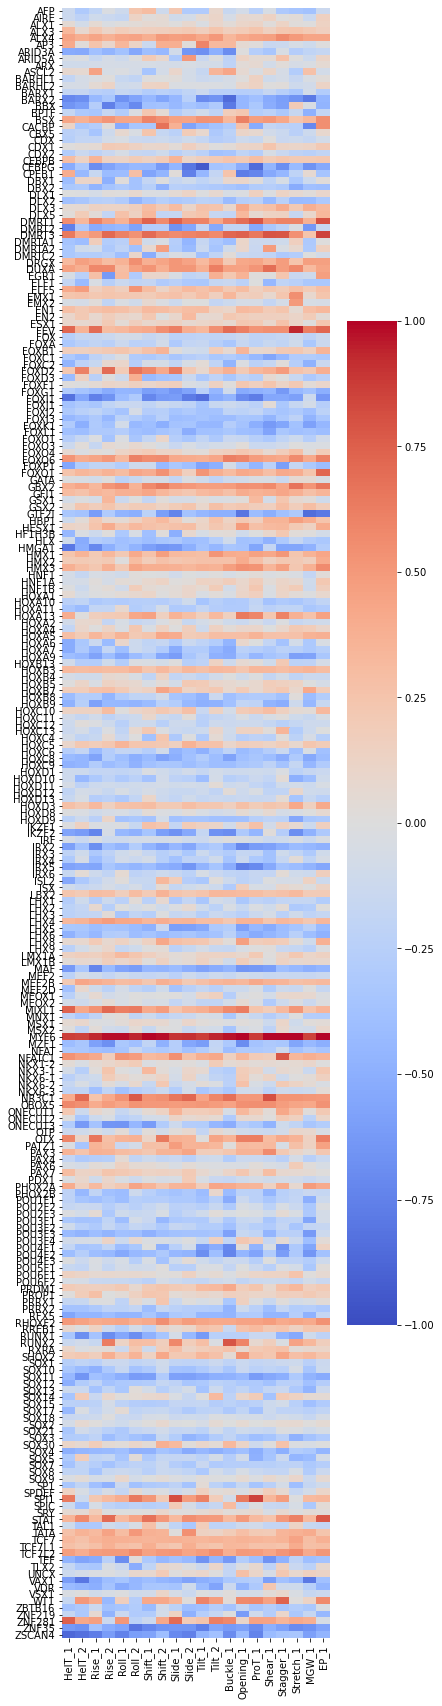

In [19]:
temp_plt = plt.figure(figsize=[6, 30])
sns.heatmap(DF_KSvmutrate_v_bytf, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_v_bytf))+0.5, DF_KSvmutrate_v_bytf.index)
plt.show()
temp_plt.savefig("data_out/heatmap_tfbs_correlations_vista_bytf.pdf")

### TFBS mutc > 50

What if we only used the ones that had lots of recorded mutations?

In [30]:
with pd.ExcelFile("data_input/TF_1kg/tfbs_shapemutrate_vista_mutc50.xlsx") as f:
    DF_KSvmutrate_v_mc = f.parse(sheet_name="KS_mutrate", index_col=0)
    DF_KSvconserve_v_mc = f.parse(sheet_name="KS_conserve", index_col=0)
    DF_mutratevconserve_v_mc = f.parse(sheet_name="conserve_mutrate", index_col=0)
    
temp_index = [item.strip("ummary_") for item in DF_KSvmutrate_v_mc.index]
DF_KSvmutrate_v_mc.index = temp_index
DF_KSvconserve_v_mc.index = temp_index
DF_mutratevconserve_v_mc.index = temp_index

In [31]:
# Patch NaNs
DF_KSvmutrate_v_mc = DF_KSvmutrate_v_mc.fillna(0)
DF_KSvconserve_v_mc = DF_KSvconserve_v_mc.fillna(0)
DF_mutratevconserve_v_mc = DF_mutratevconserve_v_mc.fillna(0)

# Remove discovered and interacting motifs
DF_KSvmutrate_v_mc = DF_KSvmutrate_v_mc[[not "disc" in item for item in DF_KSvmutrate_v_mc.index]]
DF_KSvmutrate_v_mc = DF_KSvmutrate_v_mc[[not "::" in item for item in DF_KSvmutrate_v_mc.index]]
DF_KSvconserve_v_mc = DF_KSvconserve_v_mc.loc[DF_KSvmutrate_v_mc.index]
DF_mutratevconserve_v_mc = DF_mutratevconserve_v_mc.loc[DF_KSvmutrate_v_mc.index]

# Remove bad quality rows
drop_index = []
for item in DF_KSvconserve_v_mc.index:
    if np.all(DF_KSvconserve_v_mc.loc[item] == 0):
        drop_index.append(item)
    elif np.all(DF_KSvmutrate_v_mc.loc[item] == 1):
        drop_index.append(item)
# Drop the bad indices
DF_KSvmutrate_v_mc.drop(drop_index, inplace=True)
DF_KSvconserve_v_mc.drop(drop_index, inplace=True)
DF_mutratevconserve_v_mc.drop(drop_index, inplace=True)

# Display
display(DF_KSvmutrate_v_mc)
display(DF_KSvconserve_v_mc)
display(DF_mutratevconserve_v_mc)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
ZNF35_1  -0.630740 -0.670274 -0.364787 -0.512140 -0.567846 -0.806844   
ZNF281_1  0.748436  0.424352  0.467325 -0.130708  0.510297 -0.223815   
ZNF219_1 -0.167590 -0.317352  0.064183 -0.474244 -0.135498 -0.295957   
ZBTB16_1 -0.361670 -0.308625 -0.129791 -0.371002 -0.351553 -0.281424   
WT1_1    -0.153852  0.504219  0.403376 -0.436990  0.164558 -0.268917   
...            ...       ...       ...       ...       ...       ...   
CACBP_1   0.118648 -0.326283 -0.270064  0.016879 -0.525443 -0.336173   
BPTF_1   -0.171122 -0.317797 -0.342243 -0.162232 -0.281438 -0.017779   
BBX_1    -0.649858 -0.595703 -0.271919 -0.750715 -0.548769 -0.704012   
BARX1_2  -0.256409 -0.279608 -0.490414 -0.450583 -0.344372 -0.247696   
ARID3A_2 -0.526757 -0.536696 -0.382644 -0.465882 -0.370221 -0.542908   

           Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
ZNF35_1  -0.718792 -0.659492 -0.645116 -0.655898 -0.751138 -0.558861   
ZNF281_1 -0.125336  0.427934  0.705464  0.196957  0.252463  0.619519   
ZNF219_1 -0.285260 -0.075410  0.136456 -0.489364 -0.260756 -0.165184   
ZBTB16_1 -0.414930 -0.088538 -0.219388 -0.404589 -0.378988 -0.266296   
WT1_1     0.420183  0.421945  0.338983  0.021097  0.598312  0.476797   
...            ...       ...       ...       ...       ...       ...   
CACBP_1  -0.330911  0.677990  0.372895 -0.576292 -0.432219 -0.365813   
BPTF_1    0.231125  0.053337 -0.288907 -0.185771 -0.095667 -0.208902   
BBX_1    -0.380889 -0.362837 -0.436849 -0.346591 -0.402551 -0.299657   
BARX1_2  -0.519680 -0.449614 -0.531489 -0.461107 -0.393568 -0.459296   
ARID3A_2 -0.391341 -0.445035 -0.091990 -0.641054 -0.678324 -0.494456   

          Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
ZNF35_1  -0.619958  -0.593004 -0.697229 -0.494170  -0.582222  -0.699026   
ZNF281_1  0.583708   0.114593  0.460163  0.445839   0.343779   0.418981   
ZNF219_1 -0.005358  -0.616874 -0.100547 -0.265730   0.096275  -0.323185   
ZBTB16_1 -0.364225  -0.184372 -0.343139 -0.271725  -0.346277  -0.279347   
WT1_1     0.033615   0.573845  0.579304  0.454319   0.739522   0.012877   
...            ...        ...       ...       ...        ...        ...   
CACBP_1  -0.295382   0.268088 -0.520071 -0.175483  -0.210987  -0.244745   
BPTF_1    0.186678   0.226681 -0.280017 -0.229155  -0.322242  -0.160010   
BBX_1    -0.788855  -0.450790 -0.323124 -0.509071  -0.586677   0.200373   
BARX1_2  -0.310745  -0.521852 -0.545274 -0.349569  -0.567934  -0.422214   
ARID3A_2 -0.693232   0.003729 -0.259652 -0.341647  -0.043482  -0.268348   

             MGW_1      EP_1  
ZNF35_1  -0.666680 -0.570152  
ZNF281_1  0.383171 -0.053716  
ZNF219_1 -0.171456 -0.444714  
ZBTB16_1 -0.321763 -0.034636  
WT1_1     0.130803  0.572670  
...            ...       ...  
CACBP_1  -0.712453  0.548567  
BPTF_1   -0.486120 -0.182233  
BBX_1    -0.037908 -0.474278  
BARX1_2  -0.266367 -0.489125  
ARID3A_2 -0.201261 -0.169063  

[138 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
ZNF35_1   0.728571  0.935714  0.510714  0.825000  0.628571  0.903571   
ZNF281_1  0.650000  0.835714  0.867857  0.328571  0.785714  0.175000   
ZNF219_1  0.551086  0.290046  0.580091  0.696109  0.659854  0.398813   
ZBTB16_1  0.100395  0.357963  0.104244  0.056741  0.094274  0.292623   
WT1_1    -0.323431  0.803354  0.041841  0.133892 -0.029412  0.008368   
...            ...       ...       ...       ...       ...       ...   
CACBP_1   0.543807  0.387191  0.346583  0.571863  0.435046 -0.187861   
BPTF_1   -0.085809 -0.149615 -0.514852 -0.215622 -0.205947 -0.063806   
BBX_1     0.420018  0.647007  0.432916  0.441860  0.588025  0.473637   
BARX1_2   0.120098  0.575107  0.551471  0.401961  0.293072  0.348039   
ARID3A_2  0.724372  0.709639  0.820136  0.853286  0.554943  0.703500   

           Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
ZNF35_1   0.900000  0.646429  0.760714  0.825000  0.710714  0.878571   
ZNF281_1  0.457143  0.889286  0.885714  0.564286  0.828571  0.785714   
ZNF219_1  0.594593  0.708331  0.898193  0.711857  0.777232  0.766750   
ZBTB16_1  0.336500  0.121452  0.278032 -0.023927  0.279477  0.080168   
WT1_1     0.309626  0.352941  0.071731  0.474790  0.331942 -0.067227   
...            ...       ...       ...       ...       ...       ...   
CACBP_1   0.689769 -0.300182  0.321934  0.252327  0.452448  0.696840   
BPTF_1    0.162816 -0.198020  0.176018  0.253304 -0.273128  0.030803   
BBX_1     0.344951  0.554066  0.330653  0.545130  0.788204  0.573727   
BARX1_2   0.666258  0.687922  0.529412  0.505522  0.610668  0.588235   
ARID3A_2  0.632291  0.850123  0.685504  0.697362  0.736649  0.761204   

          Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
ZNF35_1   0.625000   0.821429  0.835714  0.582143   0.885714   0.800000   
ZNF281_1  0.603571   0.717857  0.857143  0.839286   0.721429   0.850000   
ZNF219_1  0.915245   0.442319  0.737541  0.876286   0.746867   0.788657   
ZBTB16_1  0.056494   0.402122  0.408043  0.285556   0.193783   0.463493   
WT1_1    -0.125524   0.462185  0.292803  0.705952   0.451887   0.384672   
...            ...        ...       ...       ...        ...        ...   
CACBP_1   0.259938  -0.166016  0.696840  0.741245   0.606521   0.355248   
BPTF_1    0.022002   0.202420  0.149615 -0.143172  -0.061606  -0.028603   
BBX_1     0.405720   0.772809  0.368186  0.604486   0.786417  -0.007149   
BARX1_2   0.519927   0.594727  0.506144  0.341105   0.575107   0.457388   
ARID3A_2  0.290977   0.561425  0.639657  0.578270   0.494783   0.529160   

             MGW_1      EP_1  
ZNF35_1   0.828571  0.729223  
ZNF281_1  0.782143  0.582143  
ZNF219_1  0.791759  0.457622  
ZBTB16_1  0.047361  0.303158  
WT1_1     0.453782  0.476635  
...            ...       ...  
CACBP_1   0.396572 -0.190621  
BPTF_1   -0.514317 -0.184819  
BBX_1    -0.125112  0.676208  
BARX1_2   0.245098  0.628995  
ARID3A_2  0.383058  0.620394  

[138 rows x 20 columns]

conserve_mutrate
ZNF35_1          -0.637928
ZNF281_1          0.633843
ZNF219_1          0.029579
ZBTB16_1         -0.323371
WT1_1             0.388189
...                    ...
CACBP_1          -0.329061
BPTF_1            0.028922
BBX_1            -0.457114
BARX1_2          -0.593725
ARID3A_2         -0.297469

[138 rows x 1 columns]

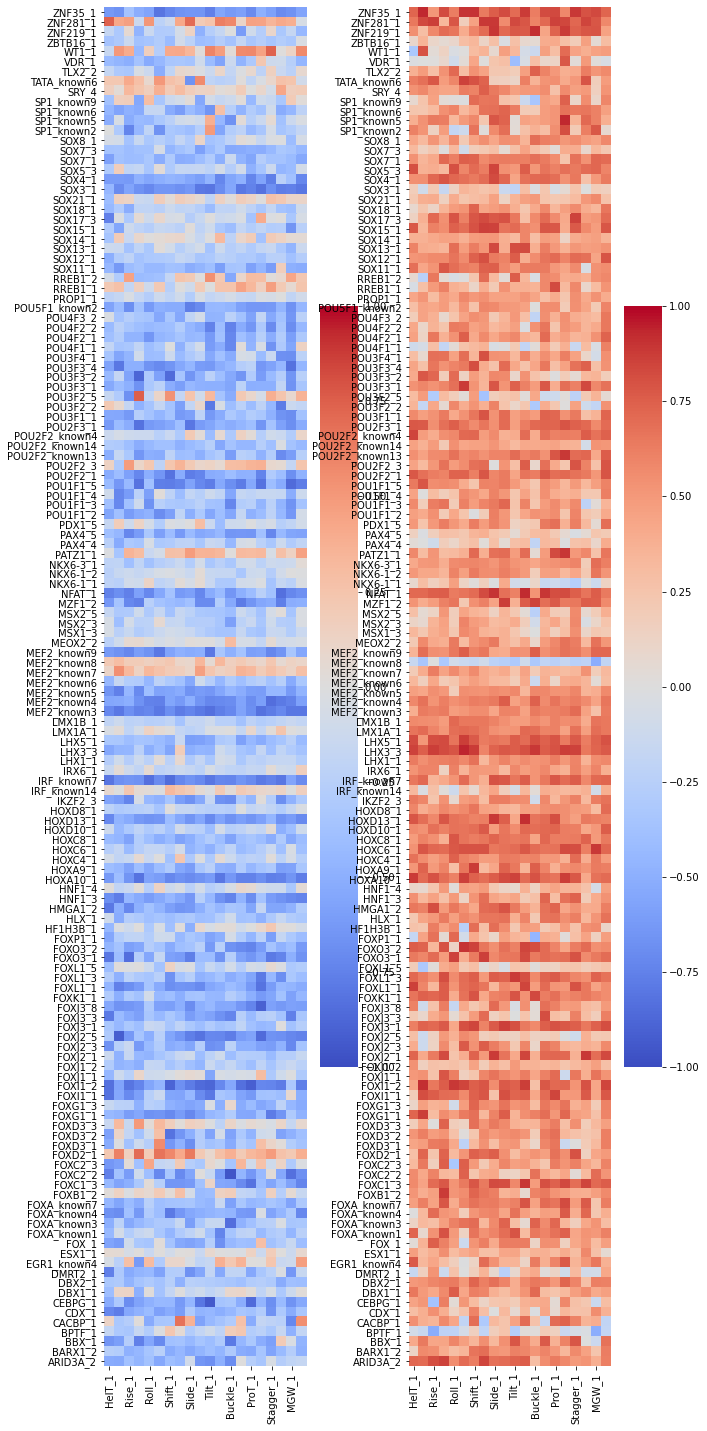

In [22]:
temp_fig = plt.figure(figsize=[10, 25])
plt.subplot(121)
sns.heatmap(DF_KSvmutrate_v_mc, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_v_mc))+0.5, DF_KSvmutrate_v_mc.index)
plt.subplot(122)
sns.heatmap(DF_KSvconserve_v_mc, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvconserve_v_mc))+0.5, DF_KSvconserve_v_mc.index)
plt.show()
temp_fig.savefig("data_out/heatmap_tfbs_correlations_vista_mutc50.pdf")

Save as xlsx:

In [16]:
with pd.ExcelWriter("data_out/Results_corrcoef_tfbs_vista.xlsx") as writer:
    DF_KSvmutrate_v_mc.to_excel(writer, sheet_name="shapechange_v_mutrate")
    DF_KSvconserve_v_mc.to_excel(writer, sheet_name="shapechange_v_entropy")

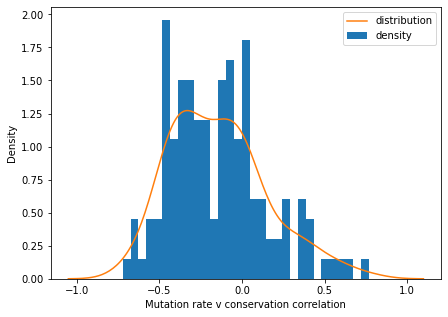

In [23]:
plt.figure(figsize=[7, 5])
plt.hist(DF_mutratevconserve_v_mc, bins=31, density=True)
sns.kdeplot(x=DF_mutratevconserve_v_mc.values.flatten())
plt.legend(["distribution", "density"])
plt.xlabel("Mutation rate v conservation correlation")
plt.show()

Aggregate by TF:

In [32]:
temp_tfbs = np.unique([item.split("_")[0] for item in DF_KSvmutrate_v_mc.index if ":" not in item])

DF_KSvmutrate_v_mc_bytf, DF_KSvconserve_v_mc_bytf, DF_mutratevconserve_v_mc_bytf = [], [], []
for item in temp_tfbs:
    DF_KSvmutrate_v_mc_bytf.append(np.mean(DF_KSvmutrate_v_mc.filter(like=item, axis=0), axis=0))
    DF_KSvconserve_v_mc_bytf.append(np.mean(DF_KSvconserve_v_mc.filter(like=item, axis=0), axis=0))
    DF_mutratevconserve_v_mc_bytf.append(np.mean(DF_mutratevconserve_v_mc.filter(like=item, axis=0), axis=0))

DF_KSvmutrate_v_mc_bytf = pd.DataFrame(DF_KSvmutrate_v_mc_bytf, index=temp_tfbs)
DF_KSvconserve_v_mc_bytf = pd.DataFrame(DF_KSvconserve_v_mc_bytf, index=temp_tfbs)
DF_mutratevconserve_v_mc_bytf = pd.DataFrame(DF_mutratevconserve_v_mc_bytf, index=temp_tfbs)
display(DF_KSvmutrate_v_mc_bytf)
display(DF_KSvconserve_v_mc_bytf)
display(DF_mutratevconserve_v_mc_bytf)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
ARID3A -0.526757 -0.536696 -0.382644 -0.465882 -0.370221 -0.542908 -0.391341   
BARX1  -0.256409 -0.279608 -0.490414 -0.450583 -0.344372 -0.247696 -0.519680   
BBX    -0.649858 -0.595703 -0.271919 -0.750715 -0.548769 -0.704012 -0.380889   
BPTF   -0.171122 -0.317797 -0.342243 -0.162232 -0.281438 -0.017779  0.231125   
CACBP   0.118648 -0.326283 -0.270064  0.016879 -0.525443 -0.336173 -0.330911   
...          ...       ...       ...       ...       ...       ...       ...   
WT1    -0.153852  0.504219  0.403376 -0.436990  0.164558 -0.268917  0.420183   
ZBTB16 -0.361670 -0.308625 -0.129791 -0.371002 -0.351553 -0.281424 -0.414930   
ZNF219 -0.167590 -0.317352  0.064183 -0.474244 -0.135498 -0.295957 -0.285260   
ZNF281  0.748436  0.424352  0.467325 -0.130708  0.510297 -0.223815 -0.125336   
ZNF35  -0.630740 -0.670274 -0.364787 -0.512140 -0.567846 -0.806844 -0.718792   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
ARID3A -0.445035 -0.091990 -0.641054 -0.678324 -0.494456 -0.693232   0.003729   
BARX1  -0.449614 -0.531489 -0.461107 -0.393568 -0.459296 -0.310745  -0.521852   
BBX    -0.362837 -0.436849 -0.346591 -0.402551 -0.299657 -0.788855  -0.450790   
BPTF    0.053337 -0.288907 -0.185771 -0.095667 -0.208902  0.186678   0.226681   
CACBP   0.677990  0.372895 -0.576292 -0.432219 -0.365813 -0.295382   0.268088   
...          ...       ...       ...       ...       ...       ...        ...   
WT1     0.421945  0.338983  0.021097  0.598312  0.476797  0.033615   0.573845   
ZBTB16 -0.088538 -0.219388 -0.404589 -0.378988 -0.266296 -0.364225  -0.184372   
ZNF219 -0.075410  0.136456 -0.489364 -0.260756 -0.165184 -0.005358  -0.616874   
ZNF281  0.427934  0.705464  0.196957  0.252463  0.619519  0.583708   0.114593   
ZNF35  -0.659492 -0.645116 -0.655898 -0.751138 -0.558861 -0.619958  -0.593004   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
ARID3A -0.259652 -0.341647  -0.043482  -0.268348 -0.201261 -0.169063  
BARX1  -0.545274 -0.349569  -0.567934  -0.422214 -0.266367 -0.489125  
BBX    -0.323124 -0.509071  -0.586677   0.200373 -0.037908 -0.474278  
BPTF   -0.280017 -0.229155  -0.322242  -0.160010 -0.486120 -0.182233  
CACBP  -0.520071 -0.175483  -0.210987  -0.244745 -0.712453  0.548567  
...          ...       ...        ...        ...       ...       ...  
WT1     0.579304  0.454319   0.739522   0.012877  0.130803  0.572670  
ZBTB16 -0.343139 -0.271725  -0.346277  -0.279347 -0.321763 -0.034636  
ZNF219 -0.100547 -0.265730   0.096275  -0.323185 -0.171456 -0.444714  
ZNF281  0.460163  0.445839   0.343779   0.418981  0.383171 -0.053716  
ZNF35  -0.697229 -0.494170  -0.582222  -0.699026 -0.666680 -0.570152  

[95 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2   Shift_1  \
ARID3A  0.724372  0.709639  0.820136  0.853286  0.554943  0.703500  0.632291   
BARX1   0.120098  0.575107  0.551471  0.401961  0.293072  0.348039  0.666258   
BBX     0.420018  0.647007  0.432916  0.441860  0.588025  0.473637  0.344951   
BPTF   -0.085809 -0.149615 -0.514852 -0.215622 -0.205947 -0.063806  0.162816   
CACBP   0.543807  0.387191  0.346583  0.571863  0.435046 -0.187861  0.689769   
...          ...       ...       ...       ...       ...       ...       ...   
WT1    -0.323431  0.803354  0.041841  0.133892 -0.029412  0.008368  0.309626   
ZBTB16  0.100395  0.357963  0.104244  0.056741  0.094274  0.292623  0.336500   
ZNF219  0.551086  0.290046  0.580091  0.696109  0.659854  0.398813  0.594593   
ZNF281  0.650000  0.835714  0.867857  0.328571  0.785714  0.175000  0.457143   
ZNF35   0.728571  0.935714  0.510714  0.825000  0.628571  0.903571  0.900000   

         Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  Buckle_1  Opening_1  \
ARID3A  0.850123  0.685504  0.697362  0.736649  0.761204  0.290977   0.561425   
BARX1   0.687922  0.529412  0.505522  0.610668  0.588235  0.519927   0.594727   
BBX     0.554066  0.330653  0.545130  0.788204  0.573727  0.405720   0.772809   
BPTF   -0.198020  0.176018  0.253304 -0.273128  0.030803  0.022002   0.202420   
CACBP  -0.300182  0.321934  0.252327  0.452448  0.696840  0.259938  -0.166016   
...          ...       ...       ...       ...       ...       ...        ...   
WT1     0.352941  0.071731  0.474790  0.331942 -0.067227 -0.125524   0.462185   
ZBTB16  0.121452  0.278032 -0.023927  0.279477  0.080168  0.056494   0.402122   
ZNF219  0.708331  0.898193  0.711857  0.777232  0.766750  0.915245   0.442319   
ZNF281  0.889286  0.885714  0.564286  0.828571  0.785714  0.603571   0.717857   
ZNF35   0.646429  0.760714  0.825000  0.710714  0.878571  0.625000   0.821429   

          ProT_1   Shear_1  Stagger_1  Stretch_1     MGW_1      EP_1  
ARID3A  0.639657  0.578270   0.494783   0.529160  0.383058  0.620394  
BARX1   0.506144  0.341105   0.575107   0.457388  0.245098  0.628995  
BBX     0.368186  0.604486   0.786417  -0.007149 -0.125112  0.676208  
BPTF    0.149615 -0.143172  -0.061606  -0.028603 -0.514317 -0.184819  
CACBP   0.696840  0.741245   0.606521   0.355248  0.396572 -0.190621  
...          ...       ...        ...        ...       ...       ...  
WT1     0.292803  0.705952   0.451887   0.384672  0.453782  0.476635  
ZBTB16  0.408043  0.285556   0.193783   0.463493  0.047361  0.303158  
ZNF219  0.737541  0.876286   0.746867   0.788657  0.791759  0.457622  
ZNF281  0.857143  0.839286   0.721429   0.850000  0.782143  0.582143  
ZNF35   0.835714  0.582143   0.885714   0.800000  0.828571  0.729223  

[95 rows x 20 columns]

conserve_mutrate
ARID3A         -0.297469
BARX1          -0.593725
BBX            -0.457114
BPTF            0.028922
CACBP          -0.329061
...                  ...
WT1             0.388189
ZBTB16         -0.323371
ZNF219          0.029579
ZNF281          0.633843
ZNF35          -0.637928

[95 rows x 1 columns]

Save as xlsx:

In [18]:
with pd.ExcelWriter("data_out/Results_corrcoef_tfbs_vista_bytf.xlsx") as writer:
    DF_KSvmutrate_v_mc_bytf.to_excel(writer, sheet_name="shapechange_v_mutrate")
    DF_KSvconserve_v_mc_bytf.to_excel(writer, sheet_name="shapechange_v_entropy")

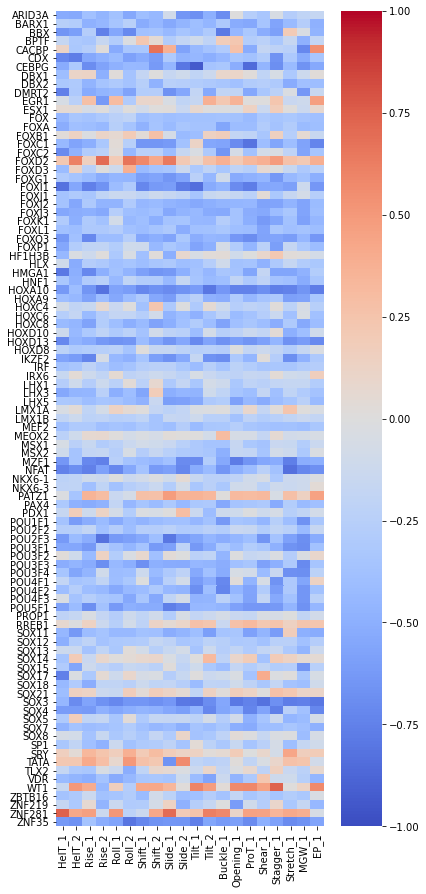

In [25]:
temp_plt = plt.figure(figsize=[6, 15])
sns.heatmap(DF_KSvmutrate_v_mc_bytf, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_v_mc_bytf))+0.5, DF_KSvmutrate_v_mc_bytf.index)
plt.show()

What if we filter the all regions TFBS motifs based on the ones that commonly occur in VISTA regions?

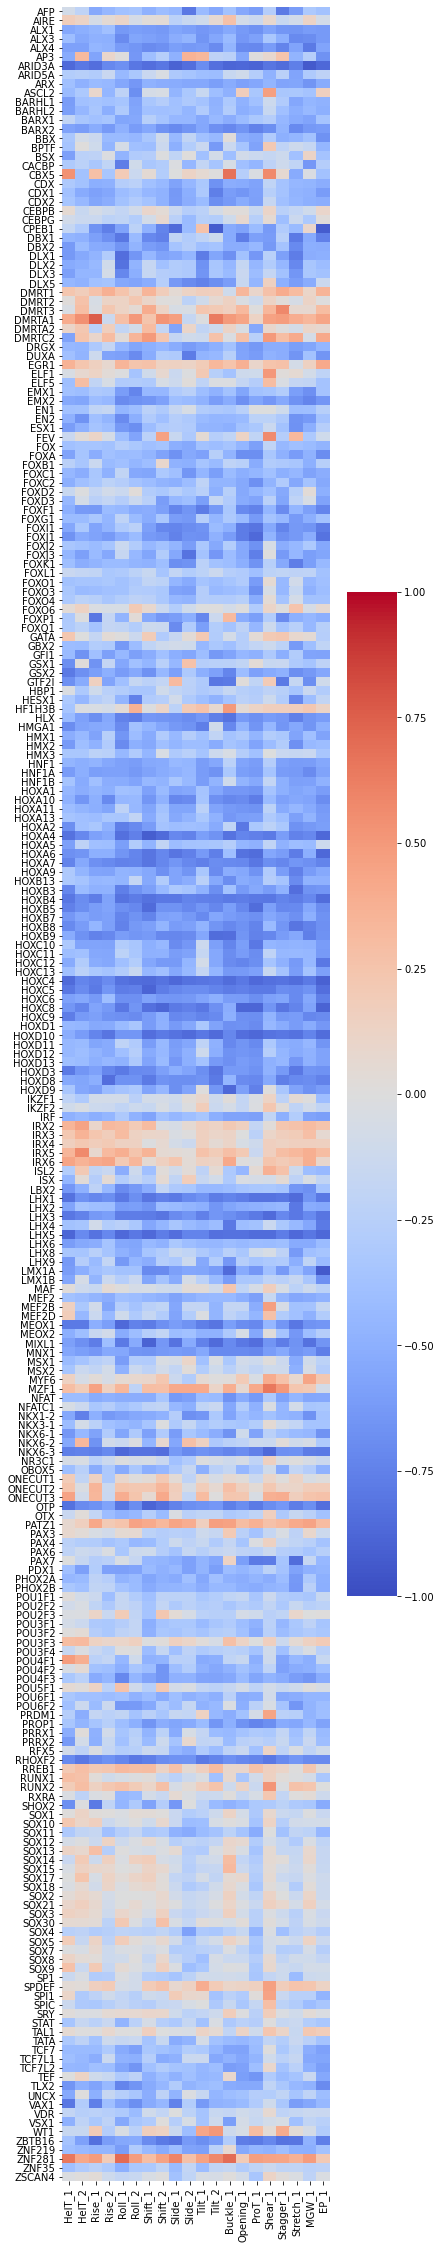

In [26]:
temp_plt = plt.figure(figsize=[6, 40])

sns.heatmap(DF_KSvmutrate_bytf.loc[DF_KSvmutrate_v_bytf.index], vmin=-1, vmax=1, cmap="coolwarm", cbar=True)

plt.yticks(np.arange(len(DF_KSvmutrate_v_bytf))+0.5, DF_KSvmutrate_v_bytf.index)
plt.show()

### Open chromatin

Use regions that intersect with DNAseI hypersensitivity regions:

In [27]:
with pd.ExcelFile("data_input/TF_1kg/tfbs_shapemutrate_dnase1.xlsx") as f:
    DF_KSvmutrate_a = f.parse(sheet_name="KS_mutrate", index_col=0)
    DF_KSvconserve_a = f.parse(sheet_name="KS_conserve", index_col=0)
    DF_mutratevconserve_a = f.parse(sheet_name="conserve_mutrate", index_col=0)
    
temp_index = [item.strip("ummary_") for item in DF_KSvmutrate_a.index]
DF_KSvmutrate_a.index = temp_index
DF_KSvconserve_a.index = temp_index
DF_mutratevconserve_a.index = temp_index

In [28]:
# Patch NaNs
DF_KSvmutrate_a = DF_KSvmutrate_a.fillna(0)
DF_KSvconserve_a = DF_KSvconserve_a.fillna(0)
DF_mutratevconserve_a = DF_mutratevconserve_a.fillna(0)

# Remove discovered and interacting motifs
DF_KSvmutrate_a = DF_KSvmutrate_a[[not "disc" in item for item in DF_KSvmutrate_a.index]]
DF_KSvmutrate_a = DF_KSvmutrate_a[[not "::" in item for item in DF_KSvmutrate_a.index]]
DF_KSvconserve_a = DF_KSvconserve_a.loc[DF_KSvmutrate_a.index]
DF_mutratevconserve_a = DF_mutratevconserve_a.loc[DF_KSvmutrate_a.index]

# Remove bad quality rows
drop_index = []
for item in DF_KSvconserve_a.index:
    if np.all(DF_KSvconserve_a.loc[item] == 0):
        drop_index.append(item)
    elif np.all(DF_KSvmutrate_a.loc[item] == 1):
        drop_index.append(item)
# Drop the bad indices
DF_KSvmutrate_a.drop(drop_index, inplace=True)
DF_KSvconserve_a.drop(drop_index, inplace=True)
DF_mutratevconserve_a.drop(drop_index, inplace=True)

# Display
display(DF_KSvmutrate_a)
display(DF_KSvconserve_a)
display(DF_mutratevconserve_a)

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
AFP_1     -0.090909 -0.300000 -0.536364 -0.500000 -0.318182 -0.327273   
AHR_1      0.064017  0.064017  0.310790  0.042334 -0.003098 -0.061951   
AHR_2     -0.036364 -0.009112  0.309091 -0.027273 -0.409091 -0.345455   
AIRE_1     0.500684  0.088577  0.458960  0.335157  0.355335  0.303352   
AIRE_2    -0.290223  0.037721 -0.464203  0.124711 -0.186297 -0.194765   
...             ...       ...       ...       ...       ...       ...   
ZNF8_1    -0.255404 -0.115980  0.071562 -0.017274 -0.179633 -0.227026   
ZSCAN16_1 -0.517028 -0.343653 -0.323013 -0.215686 -0.323013 -0.310630   
ZSCAN26_1  0.406593  0.323077  0.419780  0.243956  0.195604  0.208791   
ZSCAN4_1  -0.318627 -0.436275 -0.325980 -0.352941 -0.465686 -0.372549   
ZSCAN4_2  -0.203431 -0.039216  0.014706 -0.254902 -0.210784 -0.161765   

            Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
AFP_1     -0.527273 -0.427273 -0.181818 -0.690909 -0.400000 -0.563636   
AHR_1     -0.201342  0.243676  0.106350 -0.209603 -0.272587  0.225090   
AHR_2     -0.227791  0.236903  0.081818 -0.390909 -0.354545  0.472727   
AIRE_1     0.245554  0.657319  0.343707  0.083105  0.216826  0.457934   
AIRE_2     0.098537 -0.391840 -0.585066 -0.240185 -0.344881 -0.060816   
...             ...       ...       ...       ...       ...       ...   
ZNF8_1    -0.245533  0.083901 -0.241832  0.136956  0.135722 -0.206050   
ZSCAN16_1 -0.300310 -0.164087 -0.824561 -0.370485 -0.195046 -0.345717   
ZSCAN26_1  0.287912  0.643956  0.094505  0.081319  0.279121  0.476923   
ZSCAN4_1  -0.350490 -0.112745 -0.558824 -0.575980 -0.299020 -0.237745   
ZSCAN4_2  -0.215686 -0.171569 -0.492647 -0.335784 -0.225490 -0.098039   

           Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
AFP_1     -0.463636  -0.409091 -0.545455 -0.418182  -0.772727  -0.463636   
AHR_1     -0.104285   0.304595  0.211668  0.187919   0.273619   0.289107   
AHR_2     -0.127273  -0.054670  0.072727  0.390909   0.545455   0.272727   
AIRE_1     0.329001   0.345075  0.285910  0.305746   0.260260   0.158345   
AIRE_2    -0.089299  -0.420323 -0.341801 -0.201694  -0.444958  -0.159353   
...             ...        ...       ...       ...        ...        ...   
ZNF8_1    -0.109811  -0.035781  0.041950  0.243065   0.075264   0.022223   
ZSCAN16_1 -0.230134  -0.475748 -0.704850 -0.075335  -0.465428  -0.296182   
ZSCAN26_1  0.274725   0.402198  0.243956  0.604396   0.472527   0.595604   
ZSCAN4_1  -0.348039  -0.193627 -0.480392 -0.080882  -0.132353  -0.144608   
ZSCAN4_2  -0.039216  -0.125000 -0.392157 -0.107843  -0.093137  -0.134804   

              MGW_1      EP_1  
AFP_1     -0.245455 -0.263636  
AHR_1      0.299432  0.133196  
AHR_2      0.163636  0.287017  
AIRE_1     0.536594  0.383379  
AIRE_2    -0.224019 -0.415705  
...             ...       ...  
ZNF8_1    -0.183841  0.030846  
ZSCAN16_1  0.149639 -0.510836  
ZSCAN26_1  0.248352  0.485714  
ZSCAN4_1  -0.428922 -0.286765  
ZSCAN4_2  -0.301471 -0.262255  

[1600 rows x 20 columns]

HelT_1    HelT_2    Rise_1    Rise_2    Roll_1    Roll_2  \
AFP_1      0.544353  0.318765  0.397231  0.588490 -0.024520  0.274629   
AHR_1      0.299168  0.455072  0.167492  0.636258  0.708944  0.704730   
AHR_2      0.781839  0.707171  0.686493  0.791374  0.753235  0.591147   
AIRE_1     0.676609  0.665983  0.594004  0.563841  0.518596  0.533678   
AIRE_2     0.239696  0.249376  0.391877  0.288874  0.471647  0.231564   
...             ...       ...       ...       ...       ...       ...   
ZNF8_1     0.715686  0.693627  0.600490  0.647059  0.582465  0.674020   
ZSCAN16_1  0.729889  0.534270  0.375462  0.490098  0.579494  0.709906   
ZSCAN26_1  0.674725  0.516484  0.894505  0.564835  0.578022  0.520879   
ZSCAN4_1   0.721917  0.772254  0.767343  0.806631  0.875385  0.809087   
ZSCAN4_2   0.844172  0.866258  0.766872  0.836810  0.835583  0.876074   

            Shift_1   Shift_2   Slide_1   Slide_2    Tilt_1    Tilt_2  \
AFP_1      0.681667  0.372710  0.701284  0.436463 -0.156931  0.495312   
AHR_1      0.681555  0.568840  0.465606  0.712104  0.784789  0.700516   
AHR_2      0.831404  0.516044  0.638820  0.734166  0.810443  0.848582   
AIRE_1     0.753044  0.583721  0.617997  0.495974  0.747218  0.613884   
AIRE_2     0.491008  0.457319  0.451124  0.456932  0.502625  0.317529   
...             ...       ...       ...       ...       ...       ...   
ZNF8_1     0.558824  0.850490  0.764706  0.772059  0.803922  0.607843   
ZSCAN16_1  0.705700  0.542684  0.429099  0.706751  0.506926  0.457495   
ZSCAN26_1  0.819780  0.907692  0.534066  0.683516  0.714286  0.806593   
ZSCAN4_1   0.880296  0.895029  0.678945  0.694906  0.865563  0.775937   
ZSCAN4_2   0.840491  0.872393  0.755829  0.787731  0.813498  0.808590   

           Buckle_1  Opening_1    ProT_1   Shear_1  Stagger_1  Stretch_1  \
AFP_1     -0.220684   0.441367  0.505120  0.662051   0.372710   0.308957   
AHR_1      0.529864   0.834299  0.787949  0.869062   0.732119   0.739492   
AHR_2      0.839047   0.850517  0.867651  0.886720   0.581612   0.858116   
AIRE_1     0.437705   0.885007  0.828109  0.829823   0.851074   0.806172   
AIRE_2     0.003485   0.678041  0.587816  0.752389   0.644352   0.599433   
...             ...        ...       ...       ...        ...        ...   
ZNF8_1     0.578431   0.840686  0.926471  0.806373   0.801471   0.815451   
ZSCAN16_1  0.405961   0.659424  0.571080  0.903422   0.682562   0.588959   
ZSCAN26_1  0.815385   0.916484  0.736264  0.863736   0.859341   0.723077   
ZSCAN4_1   0.897485   0.912218  0.764888  0.925723   0.778393   0.958872   
ZSCAN4_2   0.763191   0.919019  0.828221  0.925154   0.876074   0.791412   

              MGW_1      EP_1  
AFP_1     -0.053945  0.617914  
AHR_1      0.445592  0.782682  
AHR_2      0.819978  0.917411  
AIRE_1     0.700602  0.890491  
AIRE_2     0.347733  0.695079  
...             ...       ...  
ZNF8_1     0.686275  0.877451  
ZSCAN16_1  0.340755  0.615252  
ZSCAN26_1  0.617582  0.929670  
ZSCAN4_1   0.863108  0.816453  
ZSCAN4_2   0.893252  0.936197  

[1600 rows x 20 columns]

conserve_mutrate
AFP_1             -0.367806
AHR_1              0.021079
AHR_2              0.066742
AIRE_1             0.248586
AIRE_2            -0.202678
...                     ...
ZNF8_1             0.143125
ZSCAN16_1         -0.207187
ZSCAN26_1          0.516484
ZSCAN4_1          -0.214856
ZSCAN4_2          -0.166871

[1600 rows x 1 columns]

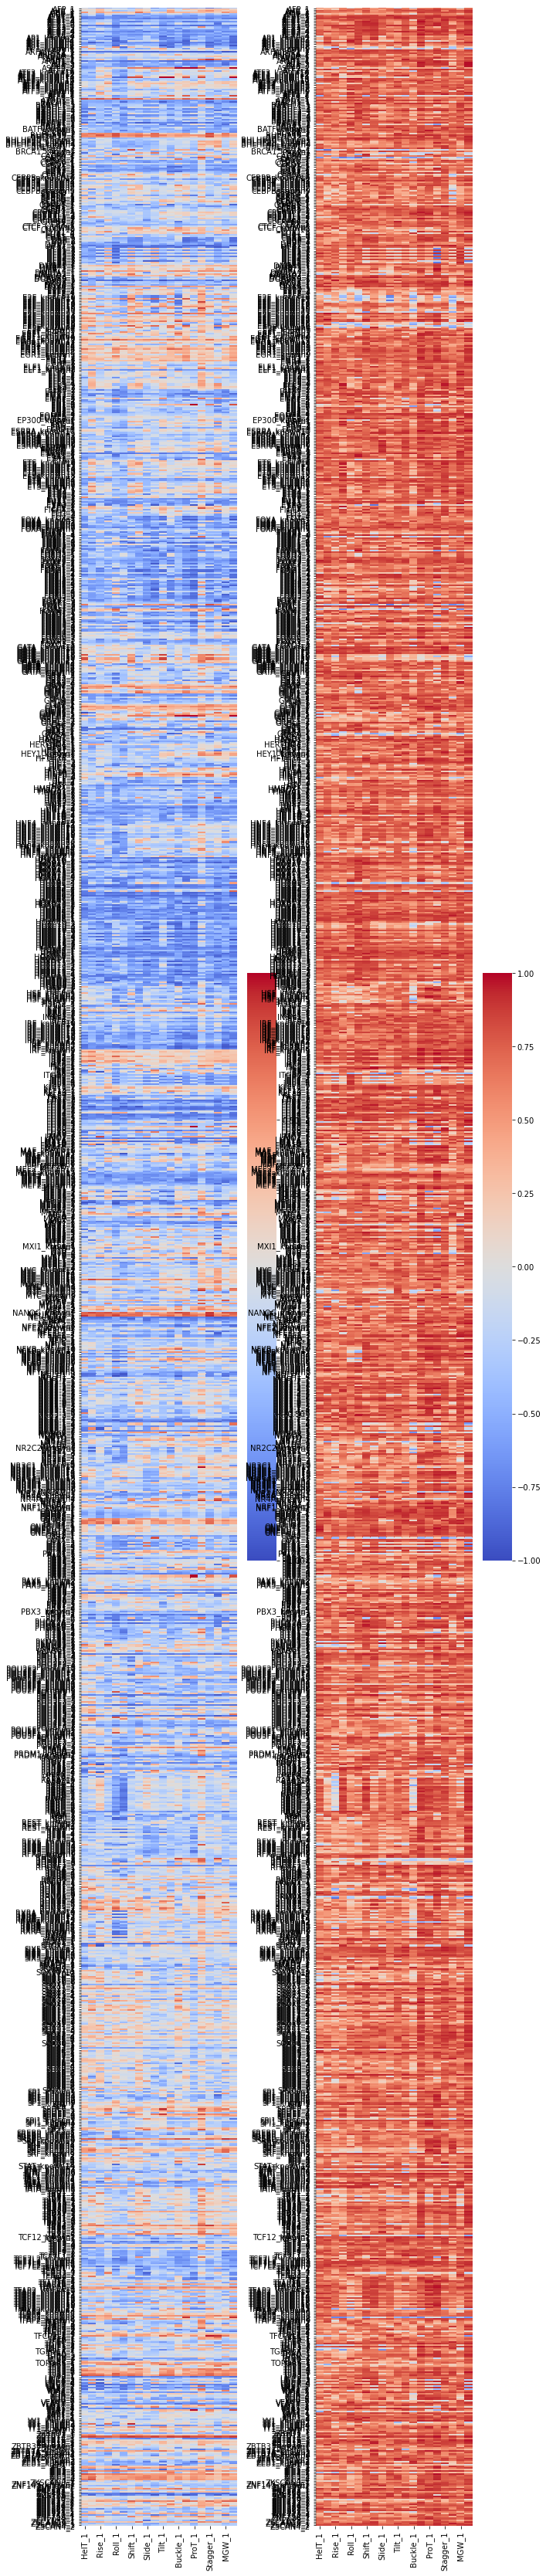

In [29]:
temp_fig = plt.figure(figsize=[10, 60])
plt.subplot(121)
sns.heatmap(DF_KSvmutrate_a, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_a))+0.5, DF_KSvmutrate_a.index)
plt.subplot(122)
sns.heatmap(DF_KSvconserve_a, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvconserve_a))+0.5, DF_KSvconserve_a.index)
plt.show()

Save outputs as xlsx:

In [30]:
with pd.ExcelWriter("data_out/Results_corrcoef_tfbs_dnase1.xlsx") as writer:
    DF_KSvmutrate_a.to_excel(writer, sheet_name="shapechange_v_mutrate")
    DF_KSvconserve_a.to_excel(writer, sheet_name="shapechange_v_entropy")

Aggregate by TF: 

In [15]:
temp_tfbs = np.unique([item.split("_")[0] for item in DF_KSvmutrate_a.index if ":" not in item])

DF_KSvmutrate_a_bytf, DF_KSvconserve_a_bytf, DF_mutratevconserve_a_bytf = [], [], []
for item in temp_tfbs:
    DF_KSvmutrate_a_bytf.append(np.mean(DF_KSvmutrate_a.filter(like=item, axis=0), axis=0))
    DF_KSvconserve_a_bytf.append(np.mean(DF_KSvconserve_a.filter(like=item, axis=0), axis=0))
    DF_mutratevconserve_a_bytf.append(np.mean(DF_mutratevconserve_a.filter(like=item, axis=0), axis=0))

DF_KSvmutrate_a_bytf = pd.DataFrame(DF_KSvmutrate_a_bytf, index=temp_tfbs)
DF_KSvconserve_a_bytf = pd.DataFrame(DF_KSvconserve_a_bytf, index=temp_tfbs)
DF_mutratevconserve_a_bytf = pd.DataFrame(DF_mutratevconserve_a_bytf, index=temp_tfbs)
display(DF_KSvmutrate_a_bytf)
display(DF_KSvconserve_a_bytf)
display(DF_mutratevconserve_a_bytf)

NameError: name 'DF_KSvmutrate_a' is not defined

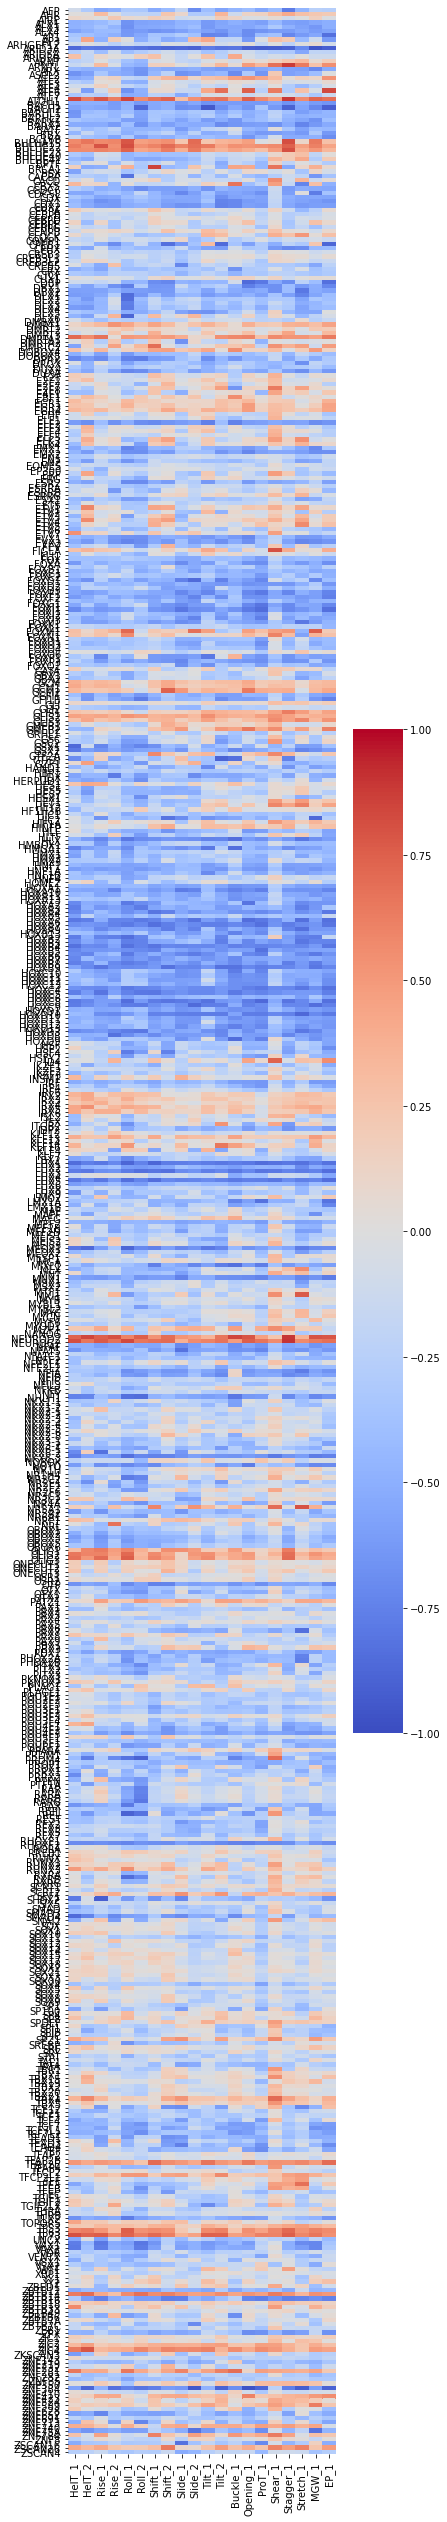

In [33]:
temp_plt = plt.figure(figsize=[6, 45])
sns.heatmap(DF_KSvmutrate_a_bytf, vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
plt.yticks(np.arange(len(DF_KSvmutrate_a_bytf))+0.5, DF_KSvmutrate_a_bytf.index)
plt.show()

### Plotting

Compare the distribution of correlation values for HelT_1: 1) all TFs, 2) TFs that commonly occurred in VISTA regions, 3) TFs that commonly occurred in DNAseI hypersensitivity regions:

Distribution of spearman correlations of KS stat of shape change vs mutation rates:

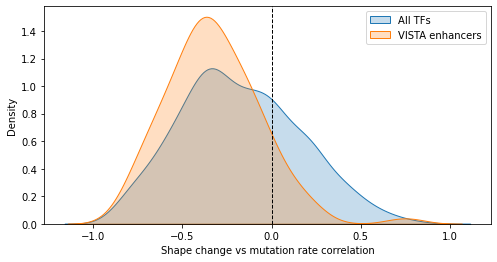

In [17]:
fig_out = plt.figure(figsize=[8, 4])

for temp_arr in [ DF_KSvmutrate_bytf["HelT_1"], DF_KSvmutrate_v_mc_bytf["HelT_1"]]:
    sns.kdeplot(x=temp_arr, fill=True)
plt.legend(["All TFs", "VISTA enhancers"])
plt.xlabel("Shape change vs mutation rate correlation")
plt.axvline(x=0, c="black", linestyle="--", linewidth=1)

plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig5d_shapemutrate_corr.pdf", dpi=300)

KS statistics vs mutation rates, but for all shapes (median value):

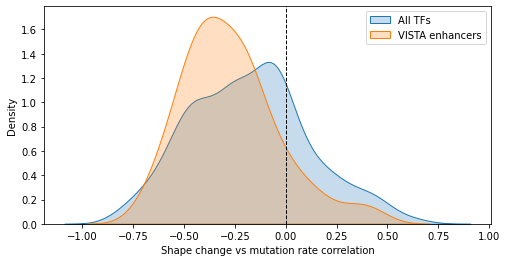

In [18]:
fig_out = plt.figure(figsize=[8, 4])

for temp_arr in [ np.median(DF_KSvmutrate_bytf, axis=1), np.median(DF_KSvmutrate_v_mc_bytf, axis=1)]:
    sns.kdeplot(x=temp_arr, fill=True)
plt.legend(["All TFs", "VISTA enhancers"])
plt.xlabel("Shape change vs mutation rate correlation")
plt.axvline(x=0, c="black", linestyle="--", linewidth=1)

plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig5d_shapemutrate_corr.pdf", dpi=300)

Per-shape:

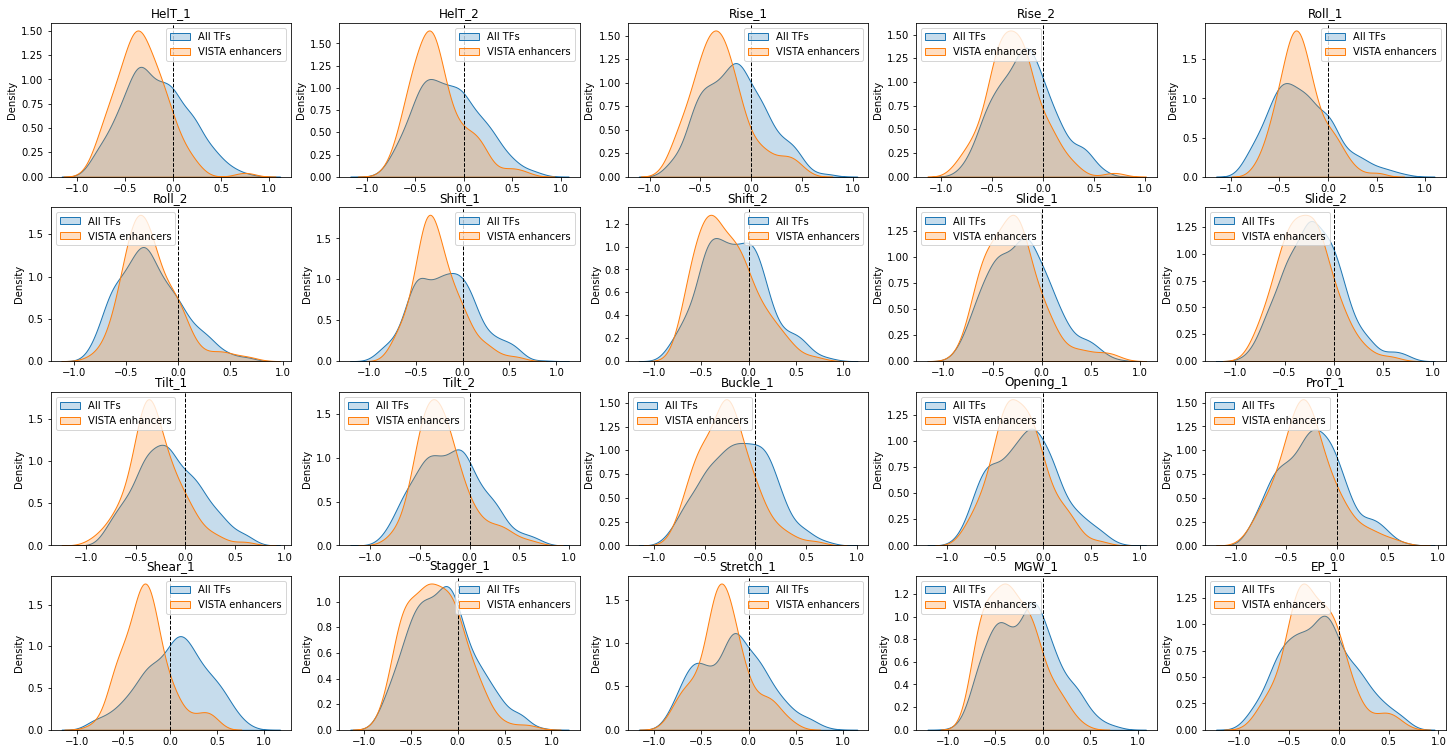

In [19]:
fig_out = plt.figure(figsize=[25, 13])

for i in range(20):
    temp_col = DF_KSvmutrate_bytf.columns[i]
    plt.subplot(4, 5, i+1)

    for temp_arr in [ DF_KSvmutrate_bytf[temp_col], DF_KSvmutrate_v_mc_bytf[temp_col]]:
        sns.kdeplot(x=temp_arr, fill=True)
    plt.legend(["All TFs", "VISTA enhancers"])
    plt.axvline(x=0, c="black", linestyle="--", linewidth=1)
    plt.xlabel("")
    plt.title(temp_col)

plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig5d_shapemutrate_corr.pdf", dpi=300)

Average correlation values in all TFs and VISTA enhancer regions?

In [21]:
print("All TFs")
print(np.median(DF_KSvmutrate_bytf, axis=0))
print(np.median(DF_KSvmutrate_bytf))
print("VISTA enhancer regions: ")
print(np.median(DF_KSvmutrate_v_mc_bytf, axis=0))
print(np.median(DF_KSvmutrate_v_mc_bytf))

All TFs
[-0.20467723 -0.17893073 -0.17199781 -0.18225733 -0.28931989 -0.30058915
 -0.19223876 -0.16697166 -0.21435712 -0.21515152 -0.19194143 -0.20065359
 -0.16019067 -0.17613636 -0.24835165  0.06823789 -0.16783217 -0.16423372
 -0.17720588 -0.19329004]
-0.18925795644950358
VISTA enhancer regions: 
[-0.34618049 -0.31795306 -0.33453174 -0.30631852 -0.29829631 -0.29709699
 -0.30345883 -0.28415936 -0.31004151 -0.29738151 -0.35057847 -0.31199689
 -0.31074454 -0.25791099 -0.32554293 -0.27172525 -0.2678991  -0.27783555
 -0.36640124 -0.26719431]
-0.30964878820630215


KS stat of shape changes vs entropy:

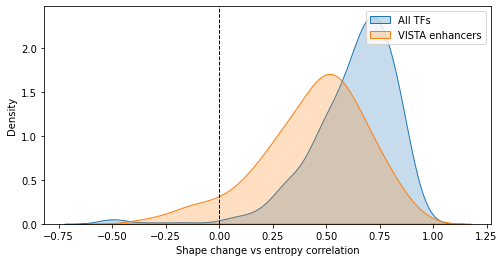

In [78]:
fig_out = plt.figure(figsize=[8, 4])

for temp_arr in [DF_KSvconserve_bytf["HelT_1"], DF_KSvconserve_v_mc_bytf["HelT_1"]]:
    sns.kdeplot(x=temp_arr, fill=True)
plt.legend(["All TFs", "VISTA enhancers"])
plt.xlabel("Shape change vs entropy correlation")
plt.axvline(x=0, c="black", linestyle="--", linewidth=1)

plt.show()
fig_out.savefig("manuscript/figures/pltout_supp_shapeentropy_corr.pdf", dpi=300)

Mutation rate vs entropy:

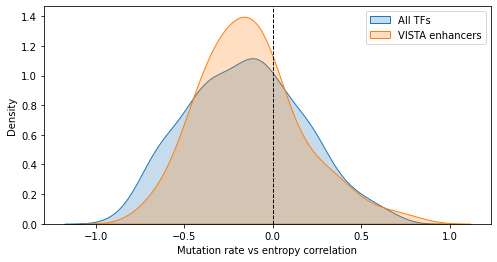

In [79]:
fig_out = plt.figure(figsize=[8, 4])

for temp_arr in [DF_mutratevconserve_bytf, DF_mutratevconserve_v_mc_bytf]:
    sns.kdeplot(x=temp_arr.values.flatten(), fill=True)
plt.legend(["All TFs", "VISTA enhancers"])
plt.xlabel("Mutation rate vs entropy correlation")
plt.axvline(x=0, c="black", linestyle="--", linewidth=1)

plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5e_mutrateentropy_corr.pdf", dpi=300)

For each TF, how do the correlations of mutation rate vs entropy differ from the median of the shape vs mutation rate correlations?

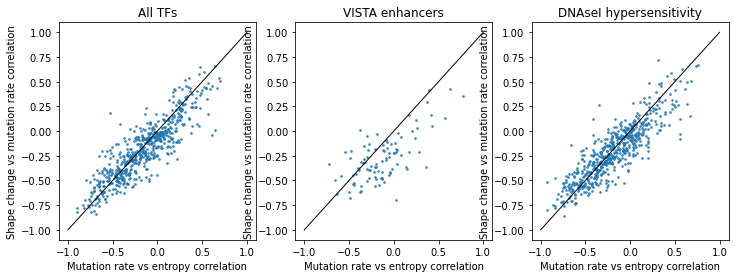

In [59]:
fig_out = plt.figure(figsize=[12, 4])

temp_list_1 = [DF_KSvmutrate_bytf, DF_KSvmutrate_v_mc_bytf, DF_KSvmutrate_a_bytf]
temp_list_2 = [DF_mutratevconserve_bytf, DF_mutratevconserve_v_mc_bytf, DF_mutratevconserve_a_bytf]

for i in range(3):
    plt.subplot(131+i)
    y_axis = np.median(temp_list_1[i], axis=1)
    x_axis = temp_list_2[i].values.flatten()
    plt.scatter(x=x_axis, y=y_axis, s=3, alpha=0.75)
    #plt.legend(["All TFs", "VISTA enhancers", "DNAseI hypersensitivity"])
    plt.plot([-1, 1], [-1, 1], c="black", linewidth=1)
    plt.xlabel("Mutation rate vs entropy correlation")
    plt.ylabel("Shape change vs mutation rate correlation")
    plt.title(["All TFs", "VISTA enhancers", "DNAseI hypersensitivity"][i])

plt.show()

What if we use the minimum?

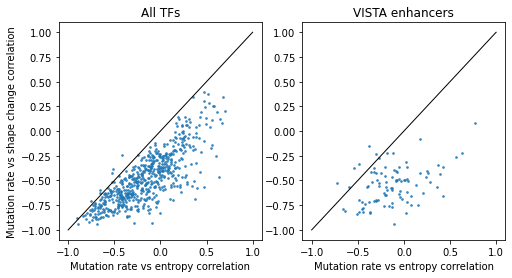

In [ ]:
fig_out = plt.figure(figsize=[8, 4])

temp_list_1 = [DF_KSvmutrate_bytf, DF_KSvmutrate_v_mc_bytf]
temp_list_2 = [DF_mutratevconserve_bytf, DF_mutratevconserve_v_mc_bytf]

for i in range(2):
    plt.subplot(121+i)
    y_axis = np.min(temp_list_1[i], axis=1).values.flatten()
    x_axis = temp_list_2[i].values.flatten()
    plt.scatter(x=x_axis, y=y_axis, s=3, alpha=0.75)
    plt.plot([-1, 1], [-1, 1], c="black", linewidth=1)
    plt.xlabel("Mutation rate vs entropy correlation")
    if i == 0:
        plt.ylabel("Mutation rate vs shape change correlation")
    plt.title(["All TFs", "VISTA enhancers"][i])

plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5f_corrscatter.pdf", dpi=300)

Which shapes do we have as the minimums?

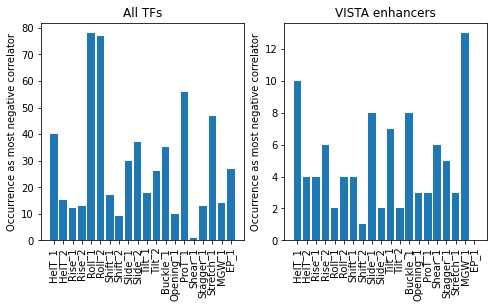

In [76]:
fig_out = plt.figure(figsize=[8, 4])

temp_list_1 = [DF_KSvmutrate_bytf, DF_KSvmutrate_v_mc_bytf]

for i in range(2):
    plt.subplot(121+i)
    temp_arr = Counter(np.argmin(temp_list_1[i].values, axis=1))
    y_axis = [temp_arr[j] for j in range(np.shape(temp_list_1[i])[1])]
    plt.bar(x=np.arange(len(y_axis))+0.5, height=y_axis)
    plt.xticks(np.arange(len(y_axis))+0.5, temp_list_1[i].columns, rotation=90)
    plt.ylabel("Occurrence as most negative correlator")
    plt.title(["All TFs", "VISTA enhancers"][i])

plt.show()

### TF family analysis

Compare the different TF families from here: http://www.edgar-wingender.de/huTF_classification.html

In [33]:
data_tffam = pd.read_csv("data_input/TF_1kg/tf_family_info.txt", sep="#")
data_tffam

TF                                Class
0                  c-Jun  Basic leucine zipper factors (bZIP)
1                   JunB  Basic leucine zipper factors (bZIP)
2                   JunD  Basic leucine zipper factors (bZIP)
3              NF-E2 p45  Basic leucine zipper factors (bZIP)
4         NF-E2L1 (NRF1)  Basic leucine zipper factors (bZIP)
...                  ...                                  ...
1567  Pur-α (PURA, PUR1)                      Uncharacterized
1568        Pur-β (PURB)                      Uncharacterized
1569        Pur-γ (PURG)                      Uncharacterized
1570       NRF-1 (α-pal)                      Uncharacterized
1571      Msx2-IP (SPEN)                      Uncharacterized

[1572 rows x 2 columns]

In [34]:
tffamily_tfs = []
for item in data_tffam["TF"]:
    tffamily_tfs.append( re.sub("[-(),]", "", item.upper()).split(" ") )
    
tffamily_family = data_tffam["Class"].values.flatten()

In [35]:
tffamily_assign = np.zeros(shape=(len(DF_KSvmutrate_bytf), ), dtype="object")
for i in range(len(DF_KSvmutrate_bytf)):
    for j in range(len(tffamily_tfs)):
        if DF_KSvmutrate_bytf.index[i] in tffamily_tfs[j]:
            tffamily_assign[i] = tffamily_family[j]
            break
        tffamily_assign[i] = "Uncharacterized"

Save family definitions:

In [36]:
temp_df = pd.DataFrame({"TF": DF_KSvmutrate_bytf.index, "Family": tffamily_assign})
temp_df.to_csv("data_out/TF_family_classification.csv", index=None)

In [43]:
# Counter:
print(len(set(tffamily_assign)))
Counter(tffamily_assign)

24


Counter({'Homeo domain factors': 164,
         'Basic helix-loop-helix factors (bHLH)': 36,
         'SAND domain factors': 4,
         'Uncharacterized': 111,
         'ARID domain factors': 3,
         'Basic leucine zipper factors (bZIP)': 24,
         'High-mobility group (HMG) domain factors': 24,
         'C2H2 zinc finger factors': 85,
         'Tryptophan cluster factors': 28,
         'DM-type intertwined zinc finger factors': 6,
         'Fork head / winged helix factors': 31,
         'Rel homology region (RHR) factors': 3,
         'T-Box factors': 10,
         'Nuclear receptors with C4 zinc fingers': 15,
         'GCM domain factors': 2,
         'Grainyhead domain factors': 1,
         'GTF2I domain factors': 1,
         'A.T hook factors': 1,
         'Heat shock factors': 3,
         'MADS box factors': 3,
         'SMAD/NF-1 DNA-binding domain factors': 5,
         'Paired box factors': 9,
         'Runt domain factors': 3,
         'TEA domain factors': 3})

Then, plot family-wise plots:

In [44]:
tffamily_ftype, tffamily_fcount = np.array(list(Counter(tffamily_assign).keys())), \
                                  np.array(list(Counter(tffamily_assign).values()))
# Greater than 10 times
tffamily_ftype_g10, tffamily_fcount_g10 = tffamily_ftype[tffamily_fcount > 10], \
                                          tffamily_fcount[tffamily_fcount > 10]
print(tffamily_ftype_g10)
print(tffamily_fcount_g10)

# Less than or equal to 10 occurrences
tffamily_ftype_l10, tffamily_fcount_l10 = tffamily_ftype[tffamily_fcount <= 10], \
                                          tffamily_fcount[tffamily_fcount <= 10]
print(tffamily_ftype_l10)
print(tffamily_fcount_l10)

['Homeo domain factors' 'Basic helix-loop-helix factors (bHLH)'
 'Uncharacterized' 'Basic leucine zipper factors (bZIP)'
 'High-mobility group (HMG) domain factors' 'C2H2 zinc finger factors'
 'Tryptophan cluster factors' 'Fork head / winged helix factors'
 'Nuclear receptors with C4 zinc fingers']
[164  36 111  24  24  85  28  31  15]
['SAND domain factors' 'ARID domain factors'
 'DM-type intertwined zinc finger factors'
 'Rel homology region (RHR) factors' 'T-Box factors' 'GCM domain factors'
 'Grainyhead domain factors' 'GTF2I domain factors' 'A.T hook factors'
 'Heat shock factors' 'MADS box factors'
 'SMAD/NF-1 DNA-binding domain factors' 'Paired box factors'
 'Runt domain factors' 'TEA domain factors']
[ 4  3  6  3 10  2  1  1  1  3  3  5  9  3  3]


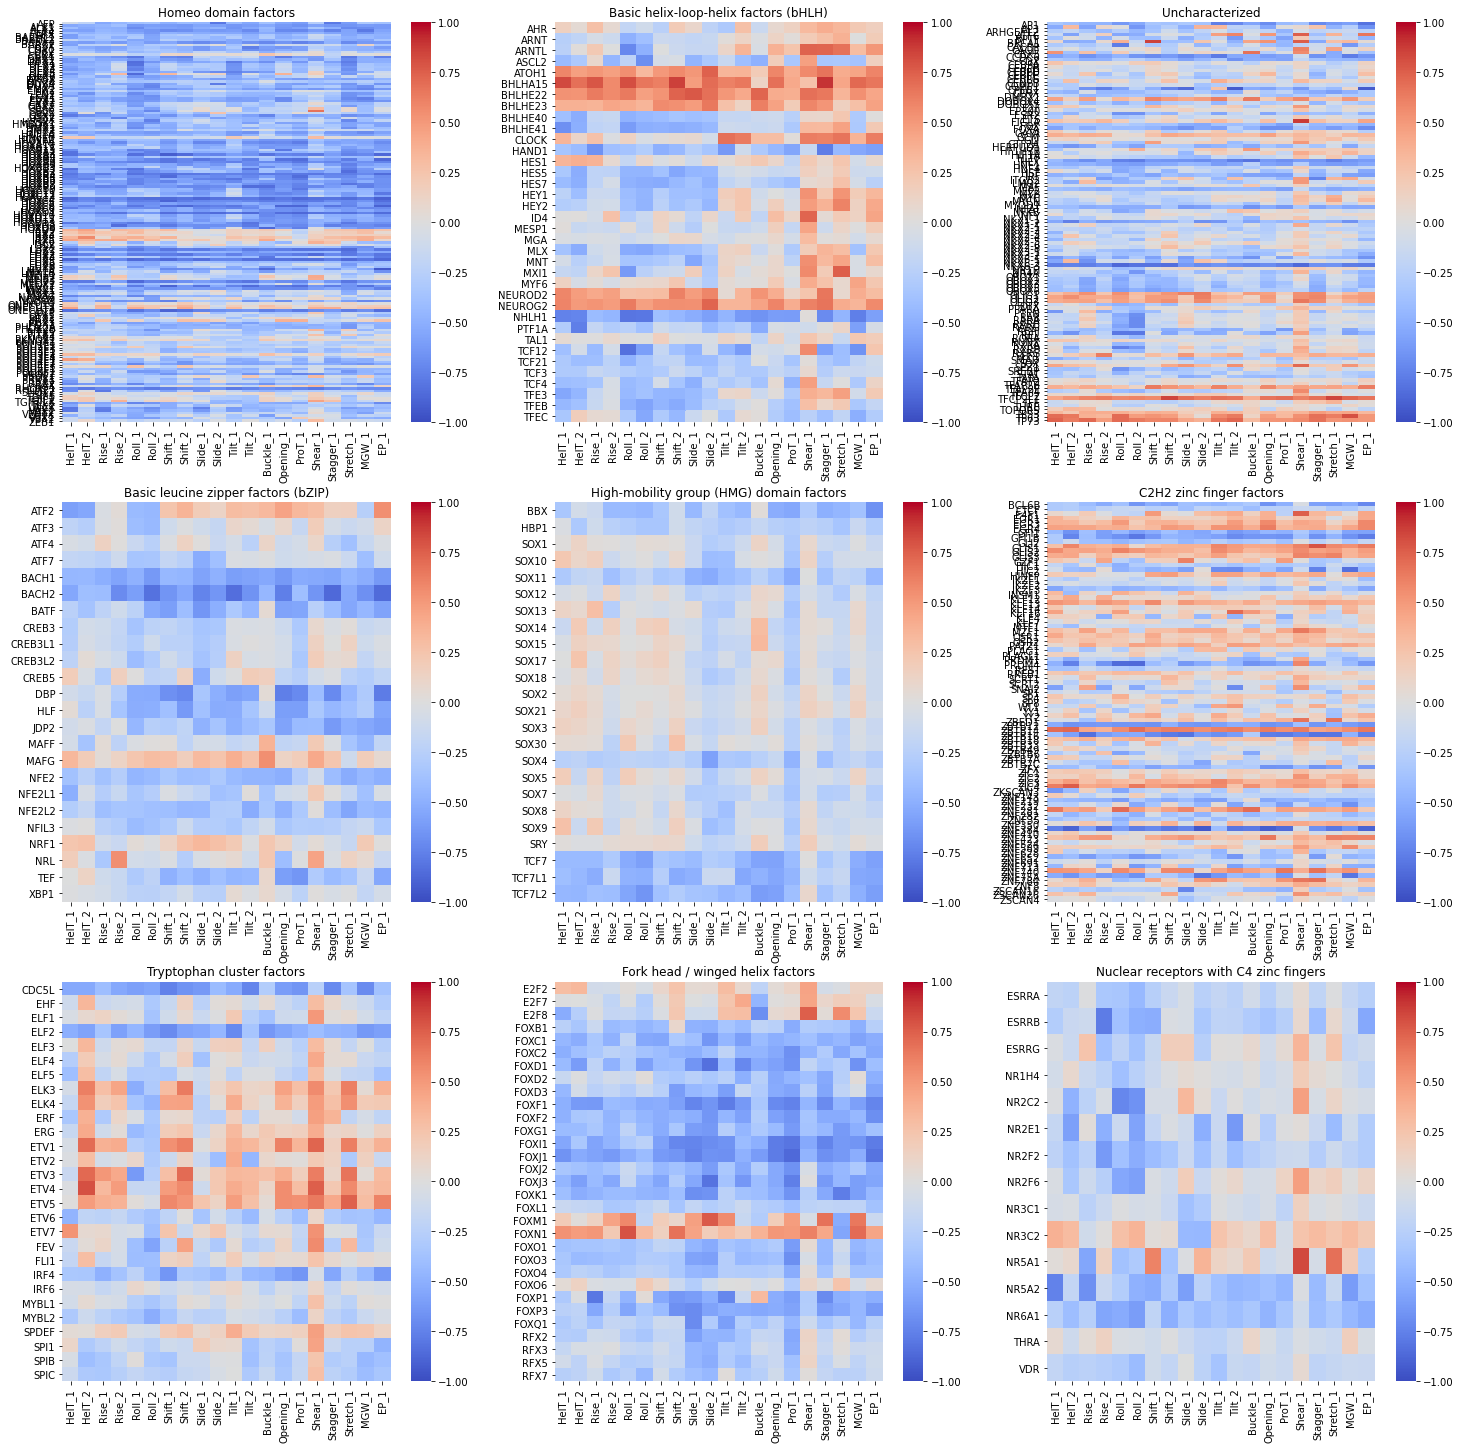

In [45]:
temp_plt = plt.figure(figsize=[25, 25])
for i in range(len(set(tffamily_ftype_g10))):
    plt.subplot(3, 3, i+1)
    temp_arr = DF_KSvmutrate_bytf[tffamily_assign == tffamily_ftype_g10[i]]
    sns.heatmap(temp_arr, 
                vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
    plt.yticks(np.arange(len(temp_arr))+0.5, temp_arr.index)
    plt.title(tffamily_ftype_g10[i])
plt.show()
#temp_plt.savefig("data_out/heatmap_tfbs_correlations_bytf.pdf")

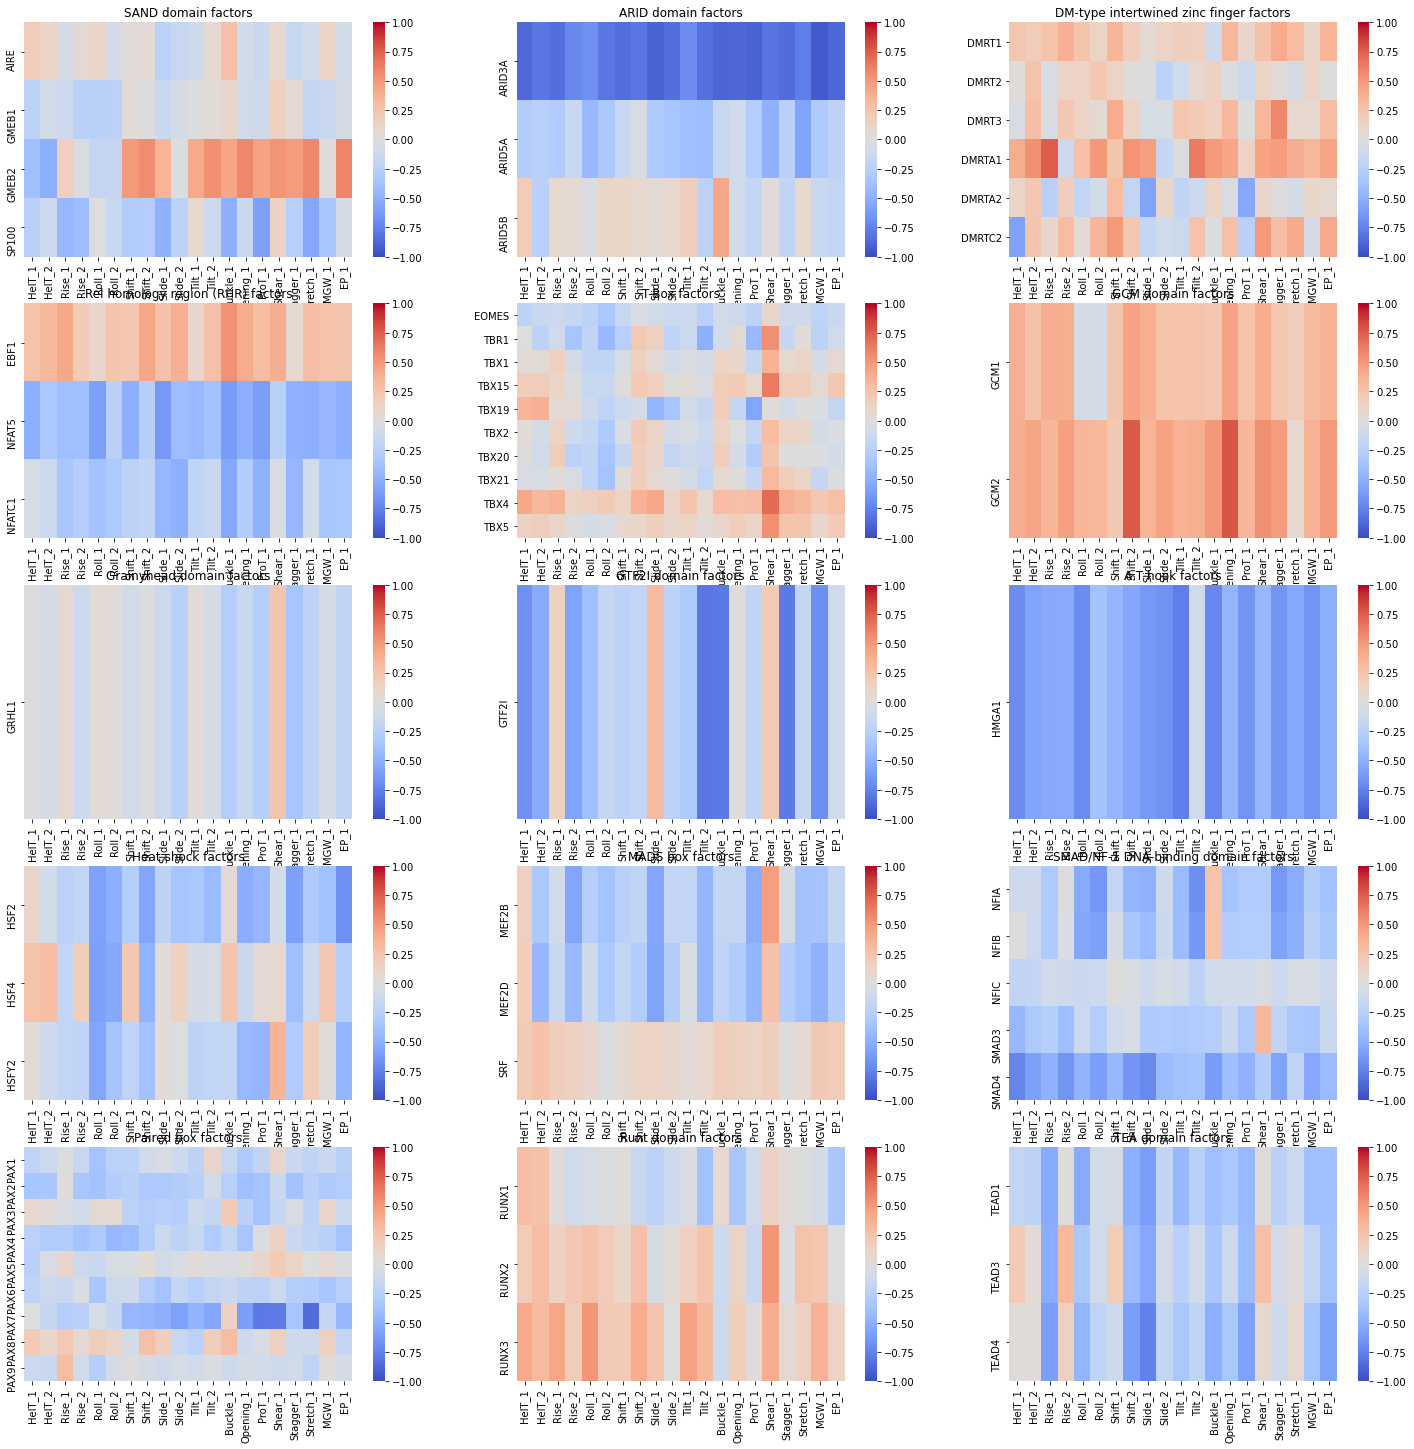

In [46]:
temp_plt = plt.figure(figsize=[25, 25])
for i in range(len(set(tffamily_ftype_l10))):
    plt.subplot(5, 3, i+1)
    temp_arr = DF_KSvmutrate_bytf[tffamily_assign == tffamily_ftype_l10[i]]
    sns.heatmap(temp_arr, 
                vmin=-1, vmax=1, cmap="coolwarm", cbar=True)
    plt.yticks(np.arange(len(temp_arr))+0.5, temp_arr.index)
    plt.title(tffamily_ftype_l10[i])
plt.show()
#temp_plt.savefig("data_out/heatmap_tfbs_correlations_bytf.pdf")

Plot the different common TF families:

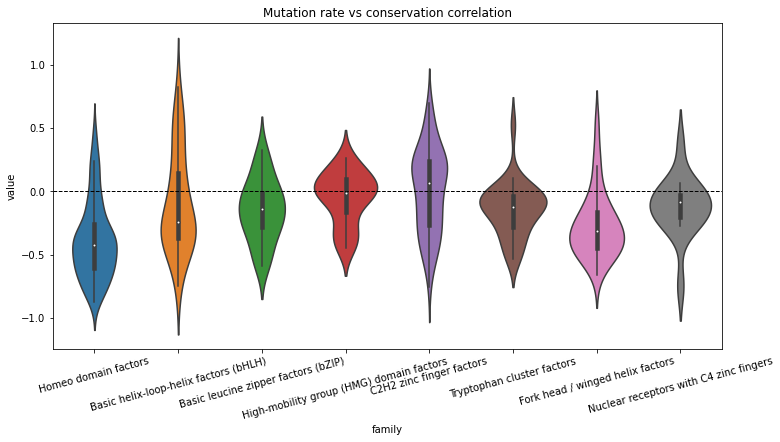

In [92]:
fig_out = plt.figure(figsize=[12, 6])

temp_df = pd.DataFrame({"value": [], "family": []})
for i in range(len(set(tffamily_ftype_g10))):
    if tffamily_ftype_g10[i] != "Uncharacterized":
        temp_df = temp_df.append(pd.DataFrame({
            "value": DF_KSvmutrate_bytf[tffamily_assign == tffamily_ftype_g10[i]]["HelT_1"], 
            "family": tffamily_ftype_g10[i]
        }))
sns.violinplot(x="family", y="value", data=temp_df)
plt.title("Mutation rate vs conservation correlation")
plt.xticks(rotation=15)
plt.axhline(y=0, c="black", linestyle="--", linewidth=1)

plt.show()
fig_out.savefig("manuscript/figures/pltout_fig5f_tffamilyviolin.pdf", dpi=300)

Save a master metatable comparing each TFBS to its corresponding TF, VISTA status, and family name:

In [65]:
df_out = pd.DataFrame({"TFBS": DF_KSvmutrate.index})
df_out["TF"] = [df_out["TFBS"][i].split("_")[0] for i in range(len(df_out))]

temp_df = pd.DataFrame({"Family": tffamily_assign})
temp_df.index = DF_KSvmutrate_bytf.index
temp_df.loc["AIRE"]
df_out["Family"] = [temp_df.loc[df_out["TF"][i]].values[0] for i in range(len(df_out))]

df_out["in_VISTA"] = [df_out["TFBS"][i] in DF_KSvmutrate_v_mc.index for i in range(len(df_out))]

display(df_out)
df_out.to_csv("data_out/TF_metatable.csv", index=False)

TFBS      TF                                 Family  in_VISTA
0          TFAP2B_4  TFAP2B                        Uncharacterized     False
1          TFAP2E_1  TFAP2E                        Uncharacterized     False
2     TFAP2_known10   TFAP2                        Uncharacterized     False
3     TFAP2_known11   TFAP2                        Uncharacterized     False
4     TFAP2_known12   TFAP2                        Uncharacterized     False
...             ...     ...                                    ...       ...
1595         AIRE_2    AIRE                    SAND domain factors     False
1596         AIRE_1    AIRE                    SAND domain factors     False
1597          AHR_2     AHR  Basic helix-loop-helix factors (bHLH)     False
1598          AHR_1     AHR  Basic helix-loop-helix factors (bHLH)     False
1599          AFP_1     AFP                   Homeo domain factors     False

[1600 rows x 4 columns]

This concludes the final portion of our study.